# 모듈

In [93]:
# from selenium import webdriver
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # 데이터프레임 컬럼 display

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 폰트 설정
plt.rcParams['figure.figsize'] = (10, 6) # 그래프 크기 설정

import warnings
warnings.filterwarnings('ignore') # 경고 무시

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, accuracy_score, classification_report, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit


# 크롤링을 위한 webdriver

from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
# 크롬 브라우저
driver = webdriver.Chrome('chromedriver.exe')
url = 'https://www.kovo.co.kr/game/v-league/11110_schedule_list.asp'
driver.get(url)
time.sleep(1)
driver.implicitly_wait(15)

NameError: name 'webdriver' is not defined

# 배구 데이터 수집

## 여자 배구 크롤링


In [ ]:
# 반복문으로 각 url 출력
seasons = [f'0{num}' for num in range(14, 19)]
yymms = [
pd.date_range('2017-10', '2018-04', freq = 'M').strftime('%Y-%m').to_list(),
pd.date_range('2018-10', '2019-04', freq = 'M').strftime('%Y-%m').to_list(),
pd.date_range('2019-10', '2020-04', freq = 'M').strftime('%Y-%m').to_list(),
pd.date_range('2020-10', '2021-05', freq = 'M').strftime('%Y-%m').to_list(),
pd.date_range('2021-10', '2022-03', freq = 'M').strftime('%Y-%m').to_list()
]
# print(seasons)
# print(yymm)

for season, dates in zip(seasons, yymms) :
    for date in dates :
        url = f'https://www.kovo.co.kr/game/v-league/11110_schedule_list.asp?season={season}&team=&yymm={date}&r_round='
        print(url)

In [ ]:
def get_result(driver) :
    #--------------------- table 태그 읽기 - 팀 별 1 ~ 5 세트 결과 ---------------------#
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find_all('table')
    set_result = pd.read_html(str(table))[1] # 1 ~ 5 세트 별 득점 결과

    #--------------------- 날짜 정보 읽기 ---------------------#
    date_selector = '#wrp_content > article.wrp_recentgame.wrp_result > table > thead > tr > th'
    date = soup.select_one(date_selector).get_text()
    date = date.replace('\xa0', '').split('/')[0].strip().split()
    date = pd.to_datetime(date[0][:-1] + '/' + date[1][:-1] + '/' + date[2][:-1])

    #
    # 첫 번째 팀 정보 읽기
    #

    #--------------------- 버튼 클릭 - 선수 기록 ---------------------#
    x_path = '//*[@id="wrp_content"]/article[2]/ul/li[2]/a/span' # 선수 기록 버튼
    cursor = driver.find_element(By.XPATH,x_path)
    cursor.click()
    time.sleep(1)

    #--------------------- table 태그 읽기 - 선수 별 출전 세트, 득점, 공격 종합 ---------------------#
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find_all('table')

    team1 = pd.read_html(str(table))[3] # 명단 table
    team1_info = pd.read_html(str(table))[4] # 출전 세트, 득점, 공격 종합 table
    team1_info.columns = ['_'.join(col).strip() for col in team1_info.columns]
    team1 = pd.concat([team1, team1_info], axis = 1)

    #--------------------- 나머지 기록 읽기 ---------------------#
    for _ in range(4) :
        #--------------------- 버튼 클릭 - 다음 기록 ---------------------#
        x_path = '//*[@id="team1"]/div/div[1]/a[2]' # 다음 기록 버튼
        cursor = driver.find_element(By.XPATH,x_path)
        cursor.click()
        time.sleep(1)


        #--------------------- table 태그 읽기 - 다음 기록들 ---------------------#
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find_all('table')

        team1_info = pd.read_html(str(table))[4] # 다음 기록
        team1_info.columns = ['_'.join(col).strip() for col in team1_info.columns]
        team1 = pd.concat([team1, team1_info], axis = 1)


    #
    # 두 번째 팀 정보 읽기
    #

    #--------------------- 버튼 클릭 - 두 번째 팀 ---------------------#
    try :
        x_path = '//*[@id="tab2"]/div[3]/ul/li[2]/a/span' # 두 번째 팀 버튼
        cursor = driver.find_element(By.XPATH,x_path)
    except :
        try :
            x_path = '//*[@id="tab2"]/div[2]/ul/li[2]/a/span' # 두 번째 팀 버튼
            cursor = driver.find_element(By.XPATH,x_path)
        except :
            x_path = '//*[@id="tab2"]/div[1]/ul/li[2]/a/span' # 두 번째 팀 버튼
            cursor = driver.find_element(By.XPATH,x_path)
    cursor.click()
    time.sleep(1)

    #--------------------- table 태그 읽기 - 선수 별 출전 세트, 득점, 공격 종합 ---------------------#
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find_all('table')

    team2 = pd.read_html(str(table))[5] # 명단 table
    team2_info = pd.read_html(str(table))[6] # 출전 세트, 득점, 공격 종합 table
    team2_info.columns = ['_'.join(col).strip() for col in team2_info.columns]
    team2 = pd.concat([team2, team2_info], axis = 1)

    #--------------------- 나머지 기록 읽기 ---------------------#
    for _ in range(4) :
        #--------------------- 버튼 클릭 - 다음 기록 ---------------------#
        x_path = '//*[@id="team2"]/div/div[1]/a[2]' # 다음 기록 버튼
        cursor = driver.find_element(By.XPATH,x_path)
        cursor.click()
        time.sleep(1)


        #--------------------- table 태그 읽기 - 다음 기록들 ---------------------#
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find_all('table')

        team2_info = pd.read_html(str(table))[6] # 다음 기록
        team2_info.columns = ['_'.join(col).strip() for col in team2_info.columns]
        team2 = pd.concat([team2, team2_info], axis = 1)
    
    return set_result, date, team1, team2

In [ ]:
def clean_result(set_result, date, team1, team2) :
    # No. 열 삭제
    team1 = team1.drop('No.', axis = 1)
    team2 = team2.drop('No.', axis = 1)

    
    # 3경기 이상 출전한 선수만 유지 (출전 세트 결측치가 3개 이상인 선수 제거)
    subset = ['출전세트_1set', '출전세트_2set', '출전세트_3set', '출전세트_4set', '출전세트_5set']

    # thresh = 3 : 정상 값(Not NaN)이 3개 이상만 유지
    team1 = team1.dropna(subset = subset, thresh = 3)
    team2 = team2.dropna(subset = subset, thresh = 3)

    # 스타팅멤버 표시 (3세트 이상 스타팅멤버라면 1 아니면 0)
    team1['스타팅멤버'] = 0
    team2['스타팅멤버'] = 0

    team1.loc[(team1.iloc[:, 1:6] == 'O').sum(axis = 1) >= 3, '스타팅멤버'] = 1
    team2.loc[(team2.iloc[:, 1:6] == 'O').sum(axis = 1) >= 3, '스타팅멤버'] = 1
    
    
    # 출전 세트 열 삭제
    subset = ['출전세트_1set', '출전세트_2set', '출전세트_3set', '출전세트_4set', '출전세트_5set']

    team1 = team1.drop(subset, axis = 1)
    team2 = team2.drop(subset, axis = 1)

    
    # 이름과 포지션 분리하기
    # "이름" 열 : 이름 정보
    # "포지션" 열 : 포지션 정보
    team1['포지션'] = team1['이름'].str.split().str[1].str.strip('()')
    team1['이름'] = team1['이름'].str.split().str[0]

    team2['포지션'] = team2['이름'].str.split().str[1].str.strip('()')
    team2['이름'] = team2['이름'].str.split().str[0]

    
    # 선수 별 득점 점유율 구하기 (개인 별 득점을 팀 전체의 득점으로 나누기)
    team1_total_score = team1['득점_득점'].sum()
    team2_total_score = team2['득점_득점'].sum()
    team1['득점점유율'] = team1['득점_득점'] / team1_total_score
    team2['득점점유율'] = team2['득점_득점'] / team2_total_score
    
    
    # 컬럼 선택
    columns = [
        '이름', #     '득점_득점','공격종합_시도','공격종합_성공','공격종합_공격차단','공격종합_범실',
        '공격종합_성공률', #     '공격종합_점유율','오픈_시도','오픈_성공','오픈_공격차단','오픈_범실',
        '오픈_성공률',    #     '오픈_점유율','시간차_시도',시간차_성공',시간차_공격차단','시간차_범실',
        '시간차_성공률',  #     '시간차_점유율','이동_시도','이동_성공','이동_공격차단','이동_범실',
        '이동_성공률',    #     '이동_점유율','후위_시도','후위_성공','후위_공격차단','후위_범실',
        '후위_성공률',    #     '후위_점유율', '속공_시도','속공_성공','속공_공격차단','속공_범실',
        '속공_성공률',    #     '속공_점유율','퀵오픈_시도','퀵오픈_성공','퀵오픈_공격차단','퀵오픈_범실',
        '퀵오픈_성공률',   #     '퀵오픈_점유율','서브_시도','서브_성공','서브_범실',
        '서브_성공률',     #     '서브_점유율','디그_시도','디그_성공','디그_실패',디그_범실','디그_세트당','디그_점유율',
    #     '세트_시도','세트_성공','세트_범실','세트_세트당','세트_점유율','리시브_시도',리시브_정확','리시브_실패',리시브_세트당','리시브_점유율',
    #     '블로킹_시도','블로킹_성공','블로킹_유효블락','블로킹_실패',블로킹_범실','블로킹_세트당','블로킹_점유율','블로킹_어시스트','벌칙_벌칙',
        '범실_범실','포지션','득점점유율','스타팅멤버']
    team1 = team1[columns]
    team2 = team2[columns]
    
    
    # 경기날짜, 팀명, 결과 정보 추가
    team1['팀명'] = set_result.iloc[0,0]
    team2['팀명'] = set_result.iloc[1,0]
    team1['결과'] = 1 if int(set_result.iloc[0,-1]) > int(set_result.iloc[1,-1]) else 0
    team2['결과'] = 0 if int(set_result.iloc[0,-1]) > int(set_result.iloc[1,-1]) else 1
    team1['경기날짜'] = date
    team2['경기날짜'] = date

    # 컬럼 순서 변경
    team1 = team1[['팀명', '경기날짜', '결과'] + columns]
    team2 = team2[['팀명', '경기날짜', '결과'] + columns]
    
    
    # 연결
    team = pd.concat([team1, team2])
    team
    
    return team

In [ ]:
## 여자 경기의 상세결과 접근하기

# 경기 스케줄 url 접속
driver = webdriver.Chrome()
url = "https://www.kovo.co.kr/game/v-league/11110_schedule_list.asp?season=014&team=&yymm=2017-10&r_round="
driver.get(url)
time.sleep(2)


# 경기 스케줄을 데이터프레임으로 저장 후 여자 경기의 인덱스를 idx에 저장
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')
table = soup.find_all('table')
df = pd.read_html(str(table))[0]
idx = df[df['구분'] == '여자'].index.to_list()
idx = [i + 1 for i in idx]

dfs = []

# 각 경기의 상세결과 버튼 클릭
for i in idx :
    # 상세결과 버튼 클릭
    try :
        x_path = f'//*[@id="type1"]/div/table/tbody/tr[{i}]/td[10]/a[3]' # 상세결과 버튼
        cursor = driver.find_element(By.XPATH,x_path)
    except :
        x_path = f'//*[@id="type1"]/div/table/tbody/tr[{i}]/td[10]/a[2]' # 상세결과 버튼
        cursor = driver.find_element(By.XPATH,x_path)
    cursor.click()
    time.sleep(1)
    
    # 함수 적용
    set_result, date, team1, team2 = get_result(driver)
    team = clean_result(set_result, date, team1, team2)
    dfs.append(team)
    
    # 다시 경기 스케줄 url로 이동
    driver.get(url)
    time.sleep(1)
df = pd.concat(dfs)
df

In [ ]:
dfs = []
driver = webdriver.Chrome()

for season, dates in zip(seasons, yymms) :
    for date in dates :
        # 경기 스케줄 url 접속
        url = f'https://www.kovo.co.kr/game/v-league/11110_schedule_list.asp?season={season}&team=&yymm={date}&r_round='
        driver.get(url)
        time.sleep(1)


        # 경기 스케줄을 데이터프레임으로 저장 후 여자 경기의 인덱스를 idx에 저장
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find_all('table')
        try :
            df = pd.read_html(str(table))[0]
            idx = df[df['구분'] == '여자'].index.to_list()
        except :
            df = pd.read_html(str(table))[2]
            idx = df[df['구분'] == '여자'].index.to_list()
        idx = [i + 1 for i in idx]

        

        # 각 경기의 상세결과 버튼 클릭
        for i in idx :
            # 상세결과 버튼 클릭
            try :
                x_path = f'//*[@id="type1"]/div/table/tbody/tr[{i}]/td[10]/a[3]' # 상세결과 버튼
                cursor = driver.find_element(By.XPATH,x_path)
            except :
                x_path = f'//*[@id="type1"]/div/table/tbody/tr[{i}]/td[10]/a[2]' # 상세결과 버튼
                cursor = driver.find_element(By.XPATH,x_path)
            cursor.click()
            time.sleep(1)

            # 함수 적용
            set_result, date, team1, team2 = get_result(driver)
            team = clean_result(set_result, date, team1, team2)
            dfs.append(team)

            # 다시 경기 스케줄 url로 이동
            driver.get(url)
            time.sleep(1)
df = pd.concat(dfs)
df

In [ ]:
dfs = []
season = seasons[4]
dates = yymms[4]
driver = webdriver.Chrome()

for date in dates :
    # 경기 스케줄 url 접속
    url = f'https://www.kovo.co.kr/game/v-league/11110_schedule_list.asp?season={season}&team=&yymm={date}&r_round='
    driver.get(url)
    time.sleep(1)


    # 경기 스케줄을 데이터프레임으로 저장 후 여자 경기의 인덱스를 idx에 저장
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find_all('table')
    try :
        df = pd.read_html(str(table))[0]
        idx = df[df['구분'] == '여자'].index.to_list()
    except :
        df = pd.read_html(str(table))[2]
        idx = df[df['구분'] == '여자'].index.to_list()
    idx = [i + 1 for i in idx]



    # 각 경기의 상세결과 버튼 클릭
    for i in idx :
        # 상세결과 버튼 클릭
        try :
            x_path = f'//*[@id="type1"]/div/table/tbody/tr[{i}]/td[10]/a[3]' # 상세결과 버튼
            cursor = driver.find_element(By.XPATH,x_path)
        except :
            x_path = f'//*[@id="type1"]/div/table/tbody/tr[{i}]/td[10]/a[2]' # 상세결과 버튼
            cursor = driver.find_element(By.XPATH,x_path)
        cursor = driver.find_element(By.XPATH,x_path)
        cursor.click()
        time.sleep(1)

        # 함수 적용
        set_result, date, team1, team2 = get_result(driver)
        team = clean_result(set_result, date, team1, team2)
        dfs.append(team)

        # 다시 경기 스케줄 url로 이동
        driver.get(url)
        time.sleep(1)
        
# csv 파일로 저장
df = pd.concat(dfs)
df.to_csv(f'volleyball_{season}.csv', index = False)
# df = pd.read_csv(f'volleyball_{season}.csv')

## 남자 배구 크롤링

In [ ]:
df_man = pd.DataFrame()

for i in range(6,0,-1):
    driver.get(url)
    time.sleep(1)
    driver.find_element(By.XPATH, '//*[@id="pageheader"]/form/fieldset/div/a').click()
    driver.find_element(By.XPATH, f'/html/body/ul[1]/li[{i}]').click() # 시즌 17년부터~
    time.sleep(1)
    for w in range(2,len(driver.find_elements(By.XPATH, "/html/body/ul[3]/li"))+1):
        driver.find_element(By.XPATH, "//*[@id='wrp_content']/article/div[1]/form/fieldset/a[1]").click()
        driver.find_element(By.XPATH, f"/html/body/ul[2]/li[{w}]").click()
        driver.find_element(By.XPATH,'//*[@id="wrp_content"]/article/div[1]/a').click()
        for q in range(1,len(driver.find_elements(By.XPATH, '//*[@id="type1"]/div/table/tbody/tr'))+1):
            time.sleep(1)
            if '남자' == driver.find_element(By.XPATH,f'//*[@id="type1"]/div/table/tbody/tr[{q}]/td[3]').text:
                try:
                    if '경기요약' in driver.find_element(By.XPATH,f'//*[@id="type1"]/div/table/tbody/tr[{q}]/td[10]').text:
                        driver.find_element(By.XPATH,f'//*[@id="type1"]/div/table/tbody/tr[{q}]/td[10]/a[3]').click()
                    else:
                        driver.find_element(By.XPATH,f'//*[@id="type1"]/div/table/tbody/tr[{q}]/td[10]/a[2]').click()
                except:
                    continue
                경기번호 = driver.find_element(By.XPATH, '//*[@id="wrp_content"]/article[1]/table/thead/tr/th').text.split('제 ')[1].replace('경기','')
                경기날짜 = driver.find_element(By.XPATH,'//*[@id="wrp_content"]/article[1]/table/thead/tr/th').text.split(' (')[0].replace('  ','').replace('년','-').replace('월','-').replace('일','')
                팀1 = driver.find_element(By.XPATH, '//*[@id="wrp_content"]/article[1]/table/tbody/tr/td[1]/p[2]/span[2]').text
                팀2 = driver.find_element(By.XPATH, '//*[@id="wrp_content"]/article[1]/table/tbody/tr/td[5]/p[2]/span[2]').text
                팀1_결과 = driver.find_element(By.XPATH, '//*[@id="wrp_content"]/article[1]/table/tbody/tr/td[2]/p[2]').text
                팀2_결과 = driver.find_element(By.XPATH, '//*[@id="wrp_content"]/article[1]/table/tbody/tr/td[4]/p[2]').text

                driver.find_element(By.XPATH,'//*[@id="wrp_content"]/article[2]/ul/li[2]/a').click() # 선수기록 클릭
                # 첫번째 팀 선수기록
                html = driver.page_source
                soup = BeautifulSoup(html, 'html.parser')
                table = soup.find_all('table')

                team1 = pd.read_html(str(table))[3] # 명단 table
                team1_info = pd.read_html(str(table))[4] # 출전 세트, 득점, 공격 종합 table
                team1_info.columns = ['_'.join(col).strip() for col in team1_info.columns]
                team1 = pd.concat([team1, team1_info], axis = 1)
                for _ in range(4) :
                    #--------------------- 버튼 클릭 - 다음 기록 ---------------------#
                    x_path = '//*[@id="team1"]/div/div[1]/a[2]' # 다음 기록 버튼
                    cursor = driver.find_element(By.XPATH,x_path)
                    cursor.click()
                    time.sleep(1)

                    #--------------------- table 태그 읽기 - 다음 기록들 ---------------------#
                    html = driver.page_source
                    soup = BeautifulSoup(html, 'html.parser')
                    table = soup.find_all('table')

                    team1_info = pd.read_html(str(table))[4] # 다음 기록
                    team1_info.columns = ['_'.join(col).strip() for col in team1_info.columns]
                    team1 = pd.concat([team1, team1_info], axis = 1)

                team1['경기번호'] = 경기번호
                team1['경기날짜'] = 경기날짜
                team1['팀명'] = 팀1
                team1['결과'] = 팀1_결과

                # 두번째 팀 클릭
    #             x_path = '//*[@id="tab2"]/div[1]/ul/li[2]/a' # 두 번째 팀 버튼
                x_path = '//*[@id="tab2"]/div[@class="wrp_tab"]/ul/li[2]/a' # 두 번째 팀 버튼
                driver.find_element(By.XPATH,x_path).click()
                time.sleep(1)

                # 두번째 팀 선수기록
                html = driver.page_source
                soup = BeautifulSoup(html, 'html.parser')
                table = soup.find_all('table')

                team2 = pd.read_html(str(table))[5] # 명단 table
                team2_info = pd.read_html(str(table))[6] # 출전 세트, 득점, 공격 종합 table
                team2_info.columns = ['_'.join(col).strip() for col in team2_info.columns]
                team2 = pd.concat([team2, team2_info], axis = 1)

                #--------------------- 나머지 기록 읽기 ---------------------#
                for _ in range(4) :
                    #--------------------- 버튼 클릭 - 다음 기록 ---------------------#
                    x_path = '//*[@id="team2"]/div/div[1]/a[2]' # 다음 기록 버튼
                    cursor = driver.find_element(By.XPATH,x_path)
                    cursor.click()
                    time.sleep(1)


                    #--------------------- table 태그 읽기 - 다음 기록들 ---------------------#
                    html = driver.page_source
                    soup = BeautifulSoup(html, 'html.parser')
                    table = soup.find_all('table')

                    team2_info = pd.read_html(str(table))[6] # 다음 기록
                    team2_info.columns = ['_'.join(col).strip() for col in team2_info.columns]
                    team2 = pd.concat([team2, team2_info], axis = 1)

                team2['경기번호'] = 경기번호
                team2['경기날짜'] = 경기날짜
                team2['팀명'] = 팀2
                team2['결과'] = 팀2_결과
                teams = pd.concat([team1,team2],axis=0)
                df_man = pd.concat([df_man,teams])
                time.sleep(1)
                driver.find_element(By.XPATH, '//*[@id="wrp_content"]/article[1]/div/a').click()
                time.sleep(2)
df_man['결과'].apply(lambda x: 1 if x==3 else 0)

In [ ]:
df_man.to_csv('df_man.csv', index=False)

# 여자 배구 

## 데이터 확인 

In [3]:
woman_df = pd.read_csv('volleyball_woman.csv', encoding='utf-8')
print(woman_df.shape)
print(woman_df.columns)
display(woman_df.head())

(10997, 85)
Index(['경기번호', '팀명', '경기날짜', '결과', 'No.', '이름', '출전세트_1set', '출전세트_2set',
       '출전세트_3set', '출전세트_4set', '출전세트_5set', '득점_득점', '공격종합_시도', '공격종합_성공',
       '공격종합_공격차단', '공격종합_범실', '공격종합_성공률', '공격종합_점유율', '오픈_시도', '오픈_성공',
       '오픈_공격차단', '오픈_범실', '오픈_성공률', '오픈_점유율', '시간차_시도', '시간차_성공', '시간차_공격차단',
       '시간차_범실', '시간차_성공률', '시간차_점유율', '이동_시도', '이동_성공', '이동_공격차단', '이동_범실',
       '이동_성공률', '이동_점유율', '후위_시도', '후위_성공', '후위_공격차단', '후위_범실', '후위_성공률',
       '후위_점유율', '속공_시도', '속공_성공', '속공_공격차단', '속공_범실', '속공_성공률', '속공_점유율',
       '퀵오픈_시도', '퀵오픈_성공', '퀵오픈_공격차단', '퀵오픈_범실', '퀵오픈_성공률', '퀵오픈_점유율', '서브_시도',
       '서브_성공', '서브_범실', '서브_성공률', '서브_점유율', '디그_시도', '디그_성공', '디그_실패',
       '디그_범실', '디그_세트당', '디그_점유율', '세트_시도', '세트_성공', '세트_범실', '세트_세트당',
       '세트_점유율', '리시브_시도', '리시브_정확', '리시브_실패', '리시브_세트당', '리시브_점유율', '블로킹_시도',
       '블로킹_성공', '블로킹_유효블락', '블로킹_실패', '블로킹_범실', '블로킹_세트당', '블로킹_점유율',
       '블로킹_어시스트', '벌칙_벌칙', '범실_범실'],
      dtype='object')


경기번호       팀명        경기날짜  결과  No.       이름 출전세트_1set 출전세트_2set 출전세트_3set  \
0     1  IBK기업은행  2017-10-14   0   19   메디 (L)         O         O         O   
1     1  IBK기업은행  2017-10-14   0    7  고예림 (L)         O         O         O   
2     1  IBK기업은행  2017-10-14   0    4  김희진 (R)         O         O         O   
3     1  IBK기업은행  2017-10-14   0   17  김미연 (L)         O         O         O   
4     1  IBK기업은행  2017-10-14   0   11  김수지 (C)         O         O         O   

  출전세트_4set 출전세트_5set  득점_득점  공격종합_시도  공격종합_성공  공격종합_공격차단  공격종합_범실  공격종합_성공률  \
0         O         O     24       67       20          4        2     29.85   
1         O         O     15       40       12          6        4     30.00   
2         O         O     15       36       10          2        2     27.78   
3         O         O      7       16        5          1        0     31.25   
4         O         O      6       16        4          1        2     25.00   

   공격종합_점유율  오픈_시도  오픈_성공  오픈_공격차단  오픈_범실  오픈_성공률  오픈_점유율  시간차_시도  시간차_성공  \
0     37.43     41     11        3      1   26.83   46.59       3       3   
1     22.35     25      3        5      4   12.00   28.41       0       0   
2     20.11     10      2        0      1   20.00   11.36       9       4   
3      8.94      6      1        0      0   16.67    6.82       1       0   
4      8.94      2      0        0      0    0.00    2.27       4       2   

   시간차_공격차단  시간차_범실  시간차_성공률  시간차_점유율  이동_시도  이동_성공  이동_공격차단  이동_범실  이동_성공률  \
0         0       0   100.00    17.65      0      0        0      0    0.00   
1         0       0     0.00     0.00      0      0        0      0    0.00   
2         1       1    44.44    52.94      0      0        0      0    0.00   
3         1       0     0.00     5.88      3      1        0      0   33.33   
4         0       1    50.00    23.53      4      1        1      0   25.00   

   이동_점유율  후위_시도  후위_성공  후위_공격차단  후위_범실  후위_성공률  후위_점유율  속공_시도  속공_성공  \
0    0.00     12      1        1      0    8.33   57.14      0      0   
1    0.00      0      0        0      0    0.00    0.00      0      0   
2    0.00      9      0        1      0    0.00   42.86      0      0   
3   42.86      0      0        0      0    0.00    0.00      1      0   
4   57.14      0      0        0      0    0.00    0.00      6      1   

   속공_공격차단  속공_범실  속공_성공률  속공_점유율  퀵오픈_시도  퀵오픈_성공  퀵오픈_공격차단  퀵오픈_범실  퀵오픈_성공률  \
0        0      0    0.00    0.00      11       5         0       1    45.45   
1        0      0    0.00    0.00      15       9         1       0    60.00   
2        0      0    0.00    0.00       8       4         0       0    50.00   
3        0      0    0.00   14.29       5       3         0       0    60.00   
4        0      1   16.67   85.71       0       0         0       0     0.00   

   퀵오픈_점유율  서브_시도  서브_성공  서브_범실  서브_성공률  서브_점유율  디그_시도  디그_성공  디그_실패  디그_범실  \
0    28.21     17      1      3     0.2   17.89     24     20      4      0   
1    38.46     18      3      2     0.6   18.95     22     17      5      0   
2    20.51     13      1      3     0.2   13.68     12     11      1      0   
3    12.82     14      0      1     0.0   14.74      6      5      1      0   
4     0.00     14      1      1     0.2   14.74     11     10      1      0   

   디그_세트당  디그_점유율  세트_시도  세트_성공  세트_범실  세트_세트당  세트_점유율  리시브_시도  리시브_정확  \
0     4.0   20.17      7      0      1     0.0    3.72      28      11   
1     3.4   18.49      7      1      0     0.2    3.72      25      15   
2     2.2   10.08      7      0      1     0.0    3.72       0       0   
3     1.0    5.04      3      0      0     0.0    1.60       1       0   
4     2.0    9.24      7      0      0     0.0    3.72       0       0   

   리시브_실패  리시브_세트당  리시브_점유율  블로킹_시도  블로킹_성공  블로킹_유효블락  블로킹_실패  블로킹_범실  \
0       2      1.8    28.28      20       3         5       6       1   
1       1      2.8    25.25      10       0         7       3       0   
2       0      0.0     0.00      14       4 

In [4]:
woman_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10997 entries, 0 to 10996
Data columns (total 85 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   경기번호       10997 non-null  int64  
 1   팀명         10997 non-null  object 
 2   경기날짜       10997 non-null  object 
 3   결과         10997 non-null  int64  
 4   No.        10997 non-null  int64  
 5   이름         10997 non-null  object 
 6   출전세트_1set  8918 non-null   object 
 7   출전세트_2set  9152 non-null   object 
 8   출전세트_3set  9099 non-null   object 
 9   출전세트_4set  5272 non-null   object 
 10  출전세트_5set  2260 non-null   object 
 11  득점_득점      10997 non-null  int64  
 12  공격종합_시도    10997 non-null  int64  
 13  공격종합_성공    10997 non-null  int64  
 14  공격종합_공격차단  10997 non-null  int64  
 15  공격종합_범실    10997 non-null  int64  
 16  공격종합_성공률   10997 non-null  float64
 17  공격종합_점유율   10997 non-null  float64
 18  오픈_시도      10997 non-null  int64  
 19  오픈_성공      10997 non-null  int64  
 20  오픈_공격차

## 데이터 전처리 

### 데이터 구조 변경 (선수별 → 팀별)

In [5]:
## 선수별 -> 팀별 
N = woman_df['경기번호'].unique().shape[0] # 경기 갯수
woman_df_1 = pd.DataFrame(columns=['경기번호', '경기날짜', '팀명', '원정팀', '결과']) # 데이터를 저장할 빈데이터프레임

# 경기 갯수 만큼 홈팀 기준 경기 결과 정리 
for i in range(N):
    
    # 경기 번호(ID)
    woman_df_1.loc[i, '경기번호'] = i + 1 
    
    # 경기 번호별 경기 날짜 추출
    woman_df_1.loc[i, '경기날짜'] = woman_df.loc[woman_df['경기번호'] == i+1]['경기날짜'].unique()[0]

    # 경기 번호별 팀을 추출. 0번이 홈팀, 1번이 원정팀.
    woman_df_1.loc[i, '팀명'] = woman_df.loc[woman_df['경기번호'] == i+1]['팀명'].unique()[0]
    woman_df_1.loc[i, '원정팀'] = woman_df.loc[woman_df['경기번호'] == i+1]['팀명'].unique()[1]
    
    # 경기 결과는 홈팀의 결과 추출. 홈팀 결과를 알면 원정의 결과를 자동으로 알 수 있음. 
    woman_df_1.loc[i, '결과'] = woman_df.loc[woman_df['경기번호'] == i+1]['결과'].unique()[0]
    
display(woman_df_1.head(3))



## 선수별 -> 팀별 / 팀별 경기력 지표 구하기  
woman_df_2 = woman_df.copy()
woman_df_2.drop(columns=['No.', '이름', '결과', '출전세트_1set', '출전세트_2set', '출전세트_3set', '출전세트_4set', '출전세트_5set'], inplace=True)

# 경기력 지표 중 실수 변수 제거(성공률 및 점유율). 
woman_df_2_dtype = woman_df_2.dtypes.to_frame()   # 모든 변수의 속성 
woman_df_2_float = woman_df_2_dtype[woman_df_2_dtype[0] == 'float64'].index # 변수 속성이 실수인 변수명
woman_df_2.drop(columns = woman_df_2_float, inplace=True)

# 경기번호, 경기날짜, 팀명별 모든 선수들의 경기력 변수 합을 계산
woman_df_3 = woman_df_2.groupby(["경기번호", '경기날짜', '팀명']).sum()
display(woman_df_3.head(4))

# 성공률 변수 생성  
# 이때 값이 시도 0, 성공률 0 인 경우 결측값이 존재하므로 결측에 모두 0을 입력
woman_df_3['공격종합_성공률']  =  round(woman_df_3['공격종합_성공']/woman_df_3['공격종합_시도'],2)
woman_df_3['오픈_성공률']      =  round(woman_df_3['오픈_성공']    /woman_df_3['오픈_시도'],2)
woman_df_3['시간차_성공률']    =  round(woman_df_3['시간차_성공']  /woman_df_3['시간차_시도'],2)
woman_df_3['이동_성공률']      =  round(woman_df_3['이동_성공']    /woman_df_3['이동_시도'],2)
woman_df_3['후위_성공률']      =  round(woman_df_3['후위_성공']    /woman_df_3['후위_시도'],2)
woman_df_3['속공_성공률']      =  round(woman_df_3['속공_성공']    /woman_df_3['속공_시도'],2)
woman_df_3['퀵오픈_성공률']    =  round(woman_df_3['퀵오픈_성공']  /woman_df_3['퀵오픈_시도'],2)
woman_df_3['서브_성공률']      =  round(woman_df_3['서브_성공']    /woman_df_3['서브_시도'],2)
woman_df_3['디그_성공률']      =  round(woman_df_3['디그_성공']    /woman_df_3['디그_시도'],2)
woman_df_3['세트_성공률']      =  round(woman_df_3['세트_성공']    /woman_df_3['세트_시도'],2)
woman_df_3['리시브_성공률']    =  round(woman_df_3['리시브_정확']  /woman_df_3['리시브_시도'],2)
woman_df_3['블로킹_성공률']    =  round(woman_df_3['블로킹_성공']  /woman_df_3['블로킹_시도'],2)
woman_df_3.fillna(0, inplace=True)


## 홈팀별 경기력 데이터 병합
woman_df_4 = pd.merge(left = woman_df_1, right = woman_df_3, on=["경기번호", '경기날짜', '팀명'], how='left')
display(woman_df_4.head(3))

경기번호        경기날짜       팀명    원정팀 결과
0    1  2017-10-14  IBK기업은행   흥국생명  0
1    2  2017-10-15  KGC인삼공사   현대건설  0
2    3  2017-10-17   한국도로공사  GS칼텍스  0

득점_득점  공격종합_시도  공격종합_성공  공격종합_공격차단  공격종합_범실  오픈_시도  \
경기번호 경기날짜       팀명                                                            
1    2017-10-14 IBK기업은행     69      179       51         15       10     88   
                흥국생명        83      193       63         11       15    106   
2    2017-10-15 KGC인삼공사     79      205       67         20        7    119   
                현대건설       102      198       77          7       12     92   

                         오픈_성공  오픈_공격차단  오픈_범실  시간차_시도  시간차_성공  시간차_공격차단  \
경기번호 경기날짜       팀명                                                         
1    2017-10-14 IBK기업은행     17        9      6      17       9         2   
                흥국생명        27        7      7       9       6         0   
2    2017-10-15 KGC인삼공사     37       14      2       4       1         0   
                현대건설        31        3      6      28       9         0   

                         시간차_범실  이동_시도  이동_성공  이동_공격차단  이동_범실  후위_시도  후위_성공  \
경기번호 경기날짜       팀명                                                            
1    2017-10-14 IBK기업은행       2      7      2        1      0     21      1   
                흥국생명          0      9      2        1      1     49     21   
2    2017-10-15 KGC인삼공사       0      4      1        0      0     40     16   
                현대건설          1      0      0        0      0     33     16   

                         후위_공격차단  후위_범실  속공_시도  속공_성공  속공_공격차단  속공_범실  퀵오픈_시도  \
경기번호 경기날짜       팀명                                                              
1    2017-10-14 IBK기업은행        2      0      7      1        0      1      39   
                흥국생명           2      6     10      3        1      0      10   
2    2017-10-15 KGC인삼공사        2      4      6      1        0      0      32   
                현대건설           2      3     16      9        1      2      29   

                         퀵오픈_성공  퀵오픈_공격차단  퀵오픈_범실  서브_시도  서브_성공  서브_범실  디그_시도  \
경기번호 경기날짜       팀명                                                              
1    2017-10-14 IBK기업은행      21         1       1     95      7     10    119   
                흥국생명          4         0       1    109      5     10    145   
2    2017-10-15 KGC인삼공사      11         4       1    108      5      4    146   
                현대건설         12         1       0    116      5     13    132   

                         디그_성공  디그_실패  디그_범실  세트_시도  세트_성공  세트_범실  리시브_시도  \
경기번호 경기날짜       팀명                                                          
1    2017-10-14 IBK기업은행    102     17      0    188     51      3      99   
                흥국생명       125     20      0    195     61      2      85   
2    2017-10-15 KGC인삼공사    118     28      0    209     63      1     103   
                현대건설       117     15      0    207     75      1     104   

                         리시브_정확  리시브_실패  블로킹_시도  블로킹_성공  블로킹_유효블락  블로킹_실패  \
경기번호 경기날짜       팀명                                                          
1    2017-10-14 IBK기업은행      40       5      94      11        37      30   
                흥국생명         43       7      72      15        38      12   
2    2017-10-15 KGC인삼공사      49       5      78       7        31      22   
                현대건설         47       5     105      20        33      30   

                         블로킹_범실  블로킹_어시스트  벌칙_벌칙  범실_범실  
경기번호 경기날짜       팀명                                       
1    2017-10-14 IBK기업은행       2         8      0     25  
                흥국생명          0        10      0     27  
2    2017-10-15 KGC인삼공사       2         5      0     14  
                현대건설          3        17      0     29

경기번호        경기날짜       팀명    원정팀 결과  득점_득점  공격종합_시도  공격종합_성공  공격종합_공격차단  \
0    1  2017-10-14  IBK기업은행   흥국생명  0     69      179       51         15   
1    2  2017-10-15  KGC인삼공사   현대건설  0     79      205       67         20   
2    3  2017-10-17   한국도로공사  GS칼텍스  0     82      156       66          7   

   공격종합_범실  오픈_시도  오픈_성공  오픈_공격차단  오픈_범실  시간차_시도  시간차_성공  시간차_공격차단  시간차_범실  \
0       10     88     17        9      6      17       9         2       2   
1        7    119     37       14      2       4       1         0       0   
2        8     92     39        3      3      10       4         0       1   

   이동_시도  이동_성공  이동_공격차단  이동_범실  후위_시도  후위_성공  후위_공격차단  후위_범실  속공_시도  속공_성공  \
0      7      2        1      0     21      1        2      0      7      1   
1      4      1        0      0     40     16        2      4      6      1   
2      6      3        0      0      5      1        0      2     13      9   

   속공_공격차단  속공_범실  퀵오픈_시도  퀵오픈_성공  퀵오픈_공격차단  퀵오픈_범실  서브_시도  서브_성공  서브_범실  \
0        0      1      39      21         1       1     95      7     10   
1        0      0      32      11         4       1    108      5      4   
2        0      0      30      10         4       2    108      7     11   

   디그_시도  디그_성공  디그_실패  디그_범실  세트_시도  세트_성공  세트_범실  리시브_시도  리시브_정확  리시브_실패  \
0    119    102     17      0    188     51      3      99      40       5   
1    146    118     28      0    209     63      1     103      49       5   
2    112     90     22      0    162     61      2      98      38       9   

   블로킹_시도  블로킹_성공  블로킹_유효블락  블로킹_실패  블로킹_범실  블로킹_어시스트  벌칙_벌칙  범실_범실  공격종합_성공률  \
0      94      11        37      30       2         8      0     25      0.28   
1      78       7        31      22       2         5      0     14      0.33   
2      76       9        33      19       1         6      0     22      0.42   

   오픈_성공률  시간차_성공률  이동_성공률  후위_성공률  속공_성공률  퀵오픈_성공률  서브_성공률  디그_성공률  세트_성공률  \
0    0.19     0.53    0.29    0.05    0.14     0.54    0.07    0.86    0.27   
1    0.31     0.25    0.25    0.40    0.17     0.34    0.05    0.81    0.30   
2    0.42     0.40    0.50    0.20    0.69     0.33    0.06    0.80    0.38   

   리시브_성공률  블로킹_성공률  
0     0.40     0.12  
1     0.48     0.09  
2     0.39     0.12

### 파생변수생성

#### 날씨, 평균기온, 관중수 데이터 



In [6]:
# 날씨, 평균기온, 관중수(spectator)
woman_spec = pd.read_excel('여자관중통계.xlsx')

# # 변수 속성 변경
woman_spec["연도"] = woman_spec["연도"].astype(str)
woman_spec["월"]   = woman_spec["월"].astype(str)
woman_spec["일"]   = woman_spec["일"].astype(str)

# 날씨 변수 생성
woman_spec["경기날짜"] = woman_spec["연도"] +"-"+ woman_spec["월"].str.zfill(2) + "-" + woman_spec["일"].str.zfill(2)
display(woman_spec.head(3))

# 필요한 변수만 선택
woman_spec1 = woman_spec.loc[:, ["경기날짜", "홈팀", "날씨", "평균기온", "관중수"] ]
woman_spec1.rename(columns = {"홈팀": "팀명"}, inplace=True)
display(woman_spec1)

단체     리그            시즌    연도  월   일 요일       홈팀      원정팀        경기장  \
0  KOVO  여자 배구  2021 - 22 시즌  2022  3  21  월     흥국생명    GS칼텍스  인천삼산월드체육관   
1  KOVO  여자 배구  2021 - 22 시즌  2022  3  20  일  IBK기업은행  KGC인삼공사  화성종합실내체육관   
2  KOVO  여자 배구  2021 - 22 시즌  2022  3   5  토   한국도로공사     흥국생명    김천실내체육관   

     날씨   평균기온   관중수        경기날짜  
0  구름많음   8.3℃   489  2022-03-21  
1  구름많음   8.6℃  1576  2022-03-20  
2    맑음  10.3℃   805  2022-03-05

경기날짜       팀명    날씨   평균기온   관중수
0    2022-03-21     흥국생명  구름많음   8.3℃   489
1    2022-03-20  IBK기업은행  구름많음   8.6℃  1576
2    2022-03-05   한국도로공사    맑음  10.3℃   805
3    2022-03-03  KGC인삼공사    맑음  14.6℃   437
4    2022-03-02     흥국생명    맑음   6.4℃   784
..          ...      ...   ...    ...   ...
456  2017-10-21     흥국생명    맑음  21.5℃  1619
457  2017-10-18  IBK기업은행    흐림  18.1℃  2062
458  2017-10-17   한국도로공사  구름조금  22.3℃  1287
459  2017-10-15  KGC인삼공사  구름많음  19.9℃  1291
460  2017-10-14  IBK기업은행  구름조금  20.2℃  3482

[461 rows x 5 columns]

In [7]:
# 경기력 데이터와 날씨 및 관중수 데이터 병합 
woman_df_5 = pd.merge(left = woman_df_4, right = woman_spec1, on=['경기날짜', '팀명'], how='left')

# 날씨와 평균기온은 모델링에서 사용하지 않을 것이기 때문에 결측값이 상관없지만, 관중수는 상관있음. 
# 관중수의 값을 임의로 판단하기 어렵기 때문에 0을 집어 넣음.
woman_df_5["관중수"] = woman_df_5["관중수"].fillna(0)

display(woman_df_5.shape)
display(woman_df_5.head(3))

(474, 70)

경기번호        경기날짜       팀명    원정팀 결과  득점_득점  공격종합_시도  공격종합_성공  공격종합_공격차단  \
0    1  2017-10-14  IBK기업은행   흥국생명  0     69      179       51         15   
1    2  2017-10-15  KGC인삼공사   현대건설  0     79      205       67         20   
2    3  2017-10-17   한국도로공사  GS칼텍스  0     82      156       66          7   

   공격종합_범실  오픈_시도  오픈_성공  오픈_공격차단  오픈_범실  시간차_시도  시간차_성공  시간차_공격차단  시간차_범실  \
0       10     88     17        9      6      17       9         2       2   
1        7    119     37       14      2       4       1         0       0   
2        8     92     39        3      3      10       4         0       1   

   이동_시도  이동_성공  이동_공격차단  이동_범실  후위_시도  후위_성공  후위_공격차단  후위_범실  속공_시도  속공_성공  \
0      7      2        1      0     21      1        2      0      7      1   
1      4      1        0      0     40     16        2      4      6      1   
2      6      3        0      0      5      1        0      2     13      9   

   속공_공격차단  속공_범실  퀵오픈_시도  퀵오픈_성공  퀵오픈_공격차단  퀵오픈_범실  서브_시도  서브_성공  서브_범실  \
0        0      1      39      21         1       1     95      7     10   
1        0      0      32      11         4       1    108      5      4   
2        0      0      30      10         4       2    108      7     11   

   디그_시도  디그_성공  디그_실패  디그_범실  세트_시도  세트_성공  세트_범실  리시브_시도  리시브_정확  리시브_실패  \
0    119    102     17      0    188     51      3      99      40       5   
1    146    118     28      0    209     63      1     103      49       5   
2    112     90     22      0    162     61      2      98      38       9   

   블로킹_시도  블로킹_성공  블로킹_유효블락  블로킹_실패  블로킹_범실  블로킹_어시스트  벌칙_벌칙  범실_범실  공격종합_성공률  \
0      94      11        37      30       2         8      0     25      0.28   
1      78       7        31      22       2         5      0     14      0.33   
2      76       9        33      19       1         6      0     22      0.42   

   오픈_성공률  시간차_성공률  이동_성공률  후위_성공률  속공_성공률  퀵오픈_성공률  서브_성공률  디그_성공률  세트_성공률  \
0    0.19     0.53    0.29    0.05    0.14     0.54    0.07    0.86    0.27   
1    0.31     0.25    0.25    0.40    0.17     0.34    0.05    0.81    0.30   
2    0.42     0.40    0.50    0.20    0.69     0.33    0.06    0.80    0.38   

   리시브_성공률  블로킹_성공률    날씨   평균기온     관중수  
0     0.40     0.12  구름조금  20.2℃  3482.0  
1     0.48     0.09  구름많음  19.9℃  1291.0  
2     0.39     0.12  구름조금  22.3℃  1287.0

#### 원점팀과 이전 시즌 승률

- 2017-2018시즌  2017.10.14 - 2018.03.30
- 2018-2019시즌 2018.10.13 - 2019.03.27
- 2019-2020시즌 2019.10.12 - 2020.03.01
- 2020-2021시즌 2020.10.17 - 2021.04.17
- 2021-2022시즌 2021.10.16 - 2022.04.09 

In [8]:
woman_win = pd.read_excel('시즌별 팀별 승률.xlsx', sheet_name="여자")
woman_win

시즌      팀명      원정팀      이전승률
0    16_17    현대건설   한국도로공사  0.666667
1    16_17    현대건설    GS칼텍스  0.833333
2    16_17    현대건설     흥국생명  0.666667
3    16_17    현대건설  KGC인삼공사  0.333333
4    16_17    현대건설  IBK기업은행  0.166667
..     ...     ...      ...       ...
145  20_21  한국도로공사     현대건설  0.833333
146  20_21  한국도로공사    GS칼텍스  0.000000
147  20_21  한국도로공사  KGC인삼공사  0.333333
148  20_21  한국도로공사     흥국생명  0.333333
149  20_21  한국도로공사  IBK기업은행  0.666667

[150 rows x 4 columns]

In [9]:
# 시즌, 팀명, 원정팀별 이전 승률 병합 
# 데이터 병합을 위한 시즌 변수 생성
woman_df_6 = woman_df_5.copy()
def season(x):
    if x < "2018-05-30": return "16_17"
    elif x <  "2019-05-30": return "17_18"
    elif x <  "2020-05-30": return "18_19"
    elif x <  "2021-05-30": return "19_20"
    else: return "20_21"
woman_df_6["시즌"] = woman_df_6["경기날짜"].apply(season)

# 데이터 병합 
woman_df_7 = pd.merge(left = woman_df_6, right = woman_win, on=['시즌', '팀명', "원정팀"], how='left')

# 승률의 결측값은 신생구단인 페퍼저축은행일 때 존재함. 결측값을 0으로 채움
woman_df_7["이전승률"] = woman_df_7["이전승률"].fillna(0)
woman_df_7.head(5)

경기번호        경기날짜       팀명      원정팀 결과  득점_득점  공격종합_시도  공격종합_성공  공격종합_공격차단  \
0    1  2017-10-14  IBK기업은행     흥국생명  0     69      179       51         15   
1    2  2017-10-15  KGC인삼공사     현대건설  0     79      205       67         20   
2    3  2017-10-17   한국도로공사    GS칼텍스  0     82      156       66          7   
3    4  2017-10-18  IBK기업은행     현대건설  0     80      178       66         14   
4    5  2017-10-21     흥국생명  KGC인삼공사  1     87      173       68         10   

   공격종합_범실  오픈_시도  오픈_성공  오픈_공격차단  오픈_범실  시간차_시도  시간차_성공  시간차_공격차단  시간차_범실  \
0       10     88     17        9      6      17       9         2       2   
1        7    119     37       14      2       4       1         0       0   
2        8     92     39        3      3      10       4         0       1   
3        6     86     26        8      2      13       3         0       1   
4       12     85     29        5      9       7       3         1       0   

   이동_시도  이동_성공  이동_공격차단  이동_범실  후위_시도  후위_성공  후위_공격차단  후위_범실  속공_시도  속공_성공  \
0      7      2        1      0     21      1        2      0      7      1   
1      4      1        0      0     40     16        2      4      6      1   
2      6      3        0      0      5      1        0      2     13      9   
3     10      4        1      1     27     13        3      0      8      5   
4     10      5        0      0     30     16        0      1     12      3   

   속공_공격차단  속공_범실  퀵오픈_시도  퀵오픈_성공  퀵오픈_공격차단  퀵오픈_범실  서브_시도  서브_성공  서브_범실  \
0        0      1      39      21         1       1     95      7     10   
1        0      0      32      11         4       1    108      5      4   
2        0      0      30      10         4       2    108      7     11   
3        0      1      34      15         2       1    101      7      8   
4        2      1      29      12         2       1    107      8     13   

   디그_시도  디그_성공  디그_실패  디그_범실  세트_시도  세트_성공  세트_범실  리시브_시도  리시브_정확  리시브_실패  \
0    119    102     17      0    188     51      3      99      40       5   
1    146    118     28      0    209     63      1     103      49       5   
2    112     90     22      0    162     61      2      98      38       9   
3    129    109     20      0    188     62      5      96      51       3   
4    113    100     13      0    181     66      2      92      34       3   

   블로킹_시도  블로킹_성공  블로킹_유효블락  블로킹_실패  블로킹_범실  블로킹_어시스트  벌칙_벌칙  범실_범실  공격종합_성공률  \
0      94      11        37      30       2         8      0     25      0.28   
1      78       7        31      22       2         5      0     14      0.33   
2      76       9        33      19       1         6      0     22      0.42   
3      67       7        33      18       0         7      0     19      0.37   
4      63      11        23      18       1        10      0     28      0.39   

   오픈_성공률  시간차_성공률  이동_성공률  후위_성공률  속공_성공률  퀵오픈_성공률  서브_성공률  디그_성공률  세트_성공률  \
0    0.19     0.53    0.29    0.05    0.14     0.54    0.07    0.86    0.27   
1    0.31     0.25    0.25    0.40    0.17     0.34    0.05    0.81    0.30   
2    0.42     0.40    0.50    0.20    0.69     0.33    0.06    0.80    0.38   
3    0.30     0.23    0.40    0.48    0.62     0.44    0.07    0.84    0.33   
4    0.34     0.43    0.50    0.53    0.25     0.41    0.07    0.88    0.36   

   리시브_성공률  블로킹_성공률    날씨   평균기온     관중수     시즌      이전승률  
0     0.40     0.12  구름조금  20.2℃  3482.0  16_17  0.600000  
1     0.48     0.09  구름많음  19.9℃  1291.0  16_17  0.666667  
2     0.39     0.12  구름조금  22.3℃  1287.0  16_17  0.333333  
3     0.53     0.10    흐림  18.1℃  2062.0  16_17  0.833333  
4     0.37     0.17    맑음  21.5℃  1619.0  16_17  0.666667

## 데이터 탐색(EDA)

### 팀별 성공률 지표 비교

In [10]:
t1 = woman_df_7.groupby("팀명")[["공격종합_성공률"]].mean()
t1["공격종합_성공률"] =round(t1["공격종합_성공률"],3)
t1.reset_index(inplace=True)
t1.sort_values("공격종합_성공률", inplace=True, ascending=False)
display(t1)

sns.barplot( x= t1["팀명"], y = t1["공격종합_성공률"], palette='GnBu_d')
plt.ylim(0,0.5)
plt.show()

팀명  공격종합_성공률
0    GS칼텍스     0.409
5     현대건설     0.400
1  IBK기업은행     0.384
4   한국도로공사     0.381
2  KGC인삼공사     0.370
6     흥국생명     0.367
3   페퍼저축은행     0.359

In [21]:
t2 = woman_df_7.groupby("팀명")[["서브_성공률"]].mean()
t2["서브_성공률"] =round(t2["서브_성공률"],3)
t2.reset_index(inplace=True)
t2.sort_values("서브_성공률", inplace=True, ascending=False)
display(t2)

sns.barplot( x= t2["팀명"], y = t2["서브_성공률"], palette='GnBu_d')
plt.ylim(0,0.07)
plt.show()

팀명  서브_성공률
0    GS칼텍스   0.059
1  IBK기업은행   0.055
6     흥국생명   0.052
5     현대건설   0.050
3   페퍼저축은행   0.048
2  KGC인삼공사   0.046
4   한국도로공사   0.046

In [22]:
t3 = woman_df_7.groupby("팀명")[["디그_성공률"]].mean()
t3["디그_성공률"] =round(t3["디그_성공률"],3)
t3.reset_index(inplace=True)
t3.sort_values("디그_성공률", inplace=True, ascending=False)
display(t3)

sns.barplot( x= t3["팀명"], y = t3["디그_성공률"], palette='GnBu_d')
plt.ylim(0,0.9)
plt.show()

팀명  디그_성공률
4   한국도로공사   0.846
0    GS칼텍스   0.842
6     흥국생명   0.842
5     현대건설   0.837
1  IBK기업은행   0.832
2  KGC인삼공사   0.832
3   페퍼저축은행   0.775

In [23]:
t4 = woman_df_7.groupby("팀명")[["세트_성공률"]].mean()
t4["세트_성공률"] =round(t4["세트_성공률"],3)
t4.reset_index(inplace=True)
t4.sort_values("세트_성공률", inplace=True, ascending=False)
display(t4)

sns.barplot( x= t4["팀명"], y = t4["세트_성공률"], palette='GnBu_d')
plt.ylim(0,0.4)
plt.show()

팀명  세트_성공률
0    GS칼텍스   0.379
5     현대건설   0.367
1  IBK기업은행   0.357
4   한국도로공사   0.354
6     흥국생명   0.341
2  KGC인삼공사   0.338
3   페퍼저축은행   0.324

팀명  리시브_성공률
4   한국도로공사    0.487
0    GS칼텍스    0.431
2  KGC인삼공사    0.409
5     현대건설    0.405
1  IBK기업은행    0.382
6     흥국생명    0.375
3   페퍼저축은행    0.309

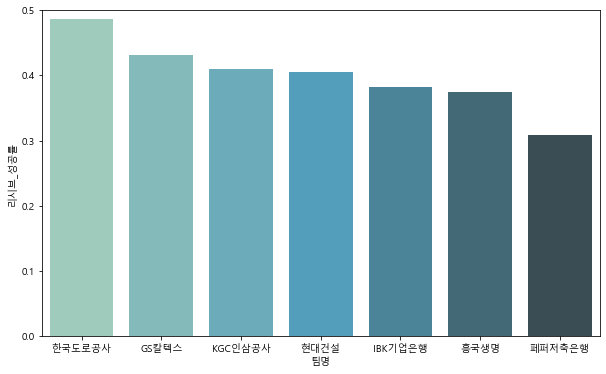

In [24]:
t5 = woman_df_7.groupby("팀명")[["리시브_성공률"]].mean()
t5["리시브_성공률"] =round(t5["리시브_성공률"],3)
t5.reset_index(inplace=True)
t5.sort_values("리시브_성공률", inplace=True, ascending=False)
display(t5)

sns.barplot( x= t5["팀명"], y = t5["리시브_성공률"], palette='GnBu_d')
plt.ylim(0,0.5)
plt.show()

팀명  블로킹_성공률
5     현대건설    0.146
0    GS칼텍스    0.139
4   한국도로공사    0.139
1  IBK기업은행    0.130
2  KGC인삼공사    0.128
6     흥국생명    0.123
3   페퍼저축은행    0.109

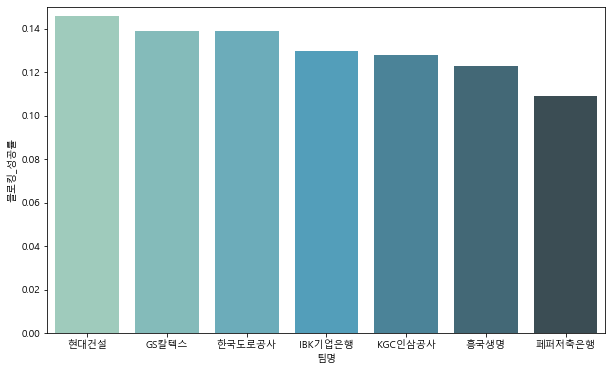

In [25]:
t6 = woman_df_7.groupby("팀명")[["블로킹_성공률"]].mean()
t6["블로킹_성공률"] =round(t6["블로킹_성공률"],3)
t6.reset_index(inplace=True)
t6.sort_values("블로킹_성공률", inplace=True, ascending=False)
display(t6)

sns.barplot( x= t6["팀명"], y = t6["블로킹_성공률"], palette='GnBu_d')
plt.ylim(0,0.15)
plt.show()

### 팀별 공격 성공률 세부 지표 비교

In [26]:
# 현대건설
hd = woman_df_7.loc[woman_df_7["팀명"]=="현대건설", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="green")
ax.fill(label_loc, hd, color = "green", alpha=0.3)
plt.title("현대건설")
plt.show()

오픈_성공률     26.05
시간차_성공률    38.13
이동_성공률     17.72
후위_성공률     29.70
속공_성공률     36.36
퀵오픈_성공률    31.45
dtype: float64


오픈_성공률     26.96
시간차_성공률    35.98
이동_성공률     34.29
후위_성공률     29.41
속공_성공률     33.60
퀵오픈_성공률    33.11
dtype: float64


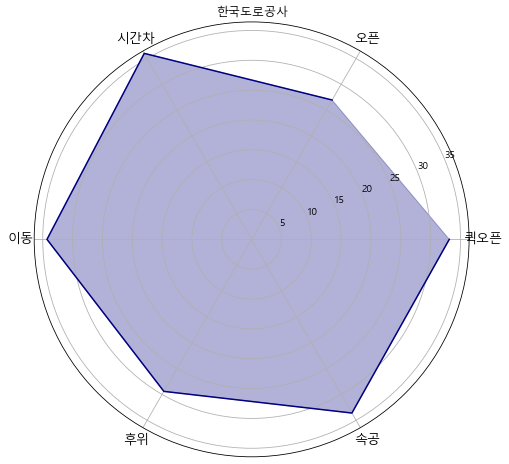

In [249]:
# 한국도로공사
hd = woman_df_7.loc[woman_df_7["팀명"]=="한국도로공사", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="navy")
ax.fill(label_loc, hd, color = "navy", alpha=0.3)
plt.title("한국도로공사")
plt.show()

오픈_성공률     26.56
시간차_성공률    35.65
이동_성공률     32.34
후위_성공률     27.04
속공_성공률     26.43
퀵오픈_성공률    31.90
dtype: float64


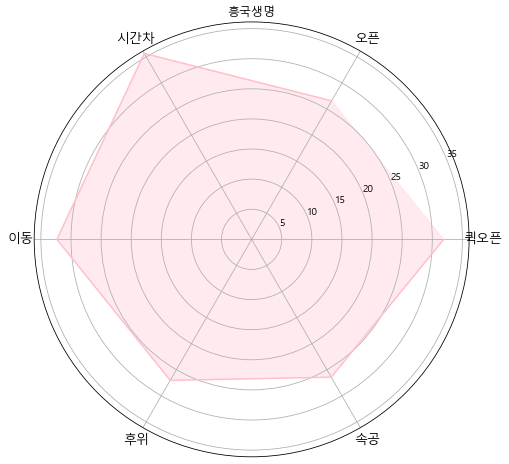

In [251]:
# 흥국생명
hd = woman_df_7.loc[woman_df_7["팀명"]=="흥국생명", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="pink")
ax.fill(label_loc, hd, color = "pink", alpha=0.3)
plt.title("흥국생명")
plt.show()

오픈_성공률     24.52
시간차_성공률    27.49
이동_성공률     25.78
후위_성공률     30.31
속공_성공률     30.07
퀵오픈_성공률    30.36
dtype: float64


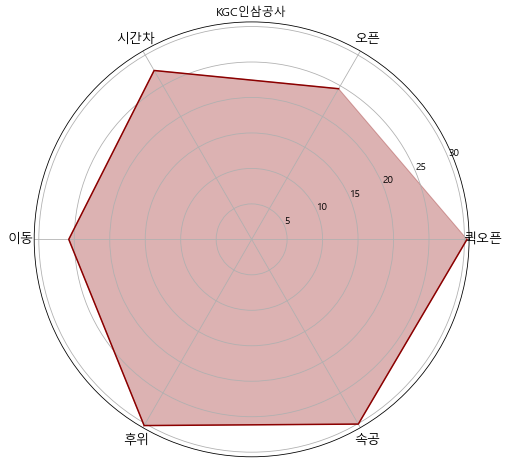

In [252]:
# KGC인삼공사
hd = woman_df_7.loc[woman_df_7["팀명"]=="KGC인삼공사", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="#8B0000")
ax.fill(label_loc, hd, color = "#8B0000", alpha=0.3)
plt.title("KGC인삼공사")
plt.show()

오픈_성공률     27.88
시간차_성공률    35.21
이동_성공률     14.16
후위_성공률     30.80
속공_성공률     30.04
퀵오픈_성공률    33.68
dtype: float64


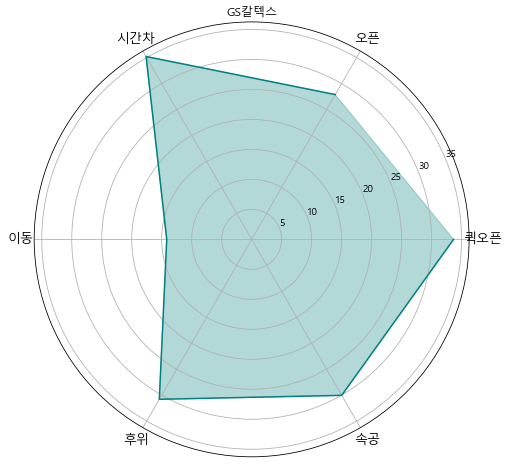

In [253]:
# GS칼텍스
hd = woman_df_7.loc[woman_df_7["팀명"]=="GS칼텍스", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="#008080")
ax.fill(label_loc, hd, color = "#008080", alpha=0.3)
plt.title("GS칼텍스")
plt.show()

오픈_성공률     27.29
시간차_성공률    34.86
이동_성공률     32.29
후위_성공률     27.83
속공_성공률     34.39
퀵오픈_성공률    34.55
dtype: float64


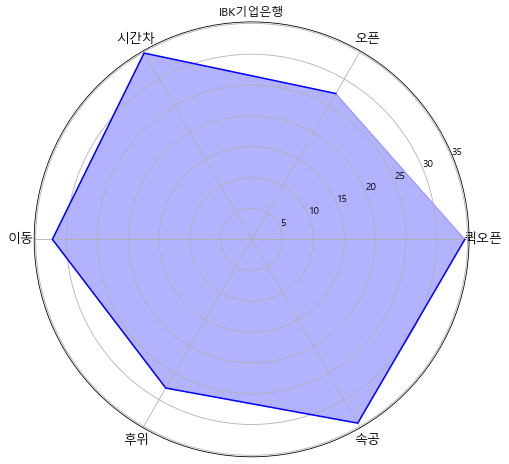

In [255]:
# IBK기업은행
hd = woman_df_7.loc[woman_df_7["팀명"]=="IBK기업은행", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="blue")
ax.fill(label_loc, hd, color = "blue", alpha=0.3)
plt.title("IBK기업은행")
plt.show()

오픈_성공률     5.52
시간차_성공률    5.83
이동_성공률     4.66
후위_성공률     5.46
속공_성공률     4.63
퀵오픈_성공률    7.22
dtype: float64


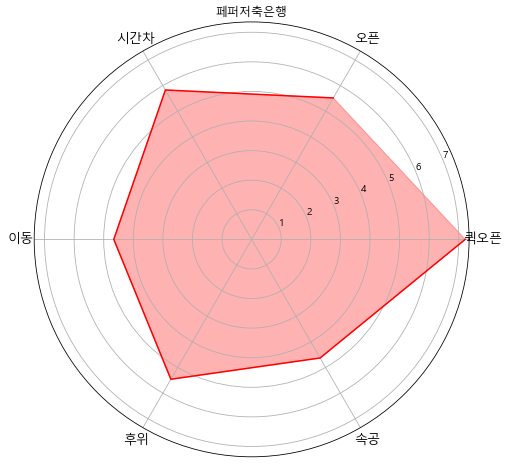

In [256]:
# IBK기업은행
hd = woman_df_7.loc[woman_df_7["팀명"]=="페퍼저축은행", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="red")
ax.fill(label_loc, hd, color = "red", alpha=0.3)
plt.title("페퍼저축은행")
plt.show()

### 팀별 승리 여부에 따른 관중수 지표 
- 승리 시 관중수가 더 많은 팀은 IBK 기업은행이다. 나머지 6개팀은 승리 시 관중이 더 적거나, 비슷한 수준을 보였다. 관중이 많아질 수록 부담감을 느끼는 경향이 있다고 추측된다.


In [ ]:
woman_df_7.columns
woman_df_7.groupby(['팀명','결과'])['관중수'].mean().plot.bar(color=['grey', '#1E90FF'])
display(woman_df_7.groupby('팀명')['결과'].mean().to_frame())
plt.xticks(rotation=30)
plt.xlabel('팀명, 결과 ( 0= 패, 1= 승리)')
plt.title('팀별 승리 여부에 따른 관중수 지표')

### 이전 승률 분석 

In [ ]:
name= woman_df_7['팀명'].unique()
plt.figure(figsize=(3,4))
for i in name :
    cond=woman_df_7.loc[woman_df_7['팀명']==i].groupby('원정팀')['이전승률'].mean()
    woman_df_7.loc[woman_df_7['팀명']==i].groupby('원정팀')['이전승률'].mean().to_frame().plot.bar(figsize=(6,4),alpha=0.6)
    print(i+' 팀이 50% 이상으로 이긴 팀')
    display(cond[cond>0.5].to_frame())
    plt.title( i +' 팀별 이전 승률 ')



## 데이터 모델 적합 

### 변수 선택

In [59]:
col = ['경기날짜', '팀명','공격종합_성공률', '서브_성공률', '디그_성공률', '세트_성공률',
       '리시브_성공률', '블로킹_성공률', '관중수', '이전승률','결과']
woman_df_8 = woman_df_7[col]
woman_df_8.head()

경기날짜       팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-14  IBK기업은행      0.28    0.07    0.86    0.27     0.40     0.12   
1  2017-10-15  KGC인삼공사      0.33    0.05    0.81    0.30     0.48     0.09   
2  2017-10-17   한국도로공사      0.42    0.06    0.80    0.38     0.39     0.12   
3  2017-10-18  IBK기업은행      0.37    0.07    0.84    0.33     0.53     0.10   
4  2017-10-21     흥국생명      0.39    0.07    0.88    0.36     0.37     0.17   

      관중수      이전승률 결과  
0  3482.0  0.600000  0  
1  1291.0  0.666667  0  
2  1287.0  0.333333  0  
3  2062.0  0.833333  0  
4  1619.0  0.666667  1

### 현대건설 

#### 시점 변경 x와 y시점의 차이는 1경기

In [60]:
# 현대건설 경기 추출
hd_data = woman_df_8[woman_df_8["팀명"]=="현대건설"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data.shape[0] * 0.8):,:]

경기날짜    팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-25  현대건설      0.51    0.10    0.88    0.46     0.39     0.21   
1  2017-10-28  현대건설      0.45    0.07    0.87    0.40     0.50     0.16   
2  2017-11-08  현대건설      0.38    0.04    0.81    0.35     0.52     0.15   

      관중수      이전승률 결과  
0  1689.0  0.666667  1  
1  1822.0  0.833333  1  
2  1232.0  0.833333  0

경기날짜    팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-25  현대건설      0.51    0.10    0.88    0.46     0.39     0.21   
1  2017-10-28  현대건설      0.45    0.07    0.87    0.40     0.50     0.16   
2  2017-11-08  현대건설      0.38    0.04    0.81    0.35     0.52     0.15   

      관중수      이전승률  결과  
0  1689.0  0.666667   1  
1  1822.0  0.833333   0  
2  1232.0  0.833333   1

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [61]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과"])
y_test = hd_data_test["결과"]

In [62]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [63]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수    훈련_정확도  \
0       로지스틱                                         {'C': 8.9}      0.58   
0     의사결정나무                                   {'max_depth': 2}  0.656667   
0     랜덤포레스트               {'max_depth': 1, 'n_estimators': 55}  0.703333   
0  AdaBoostg         {'learning_rate': 0.1, 'n_estimators': 10}  0.703333   
0   LightGBM             {'learning_rate': 0.4, 'max_depth': 1}  0.706667   
0    XGBOOST  {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...  0.626667   
0    Bagging  {'base_estimator': LGBMClassifier(), 'n_estima...       0.7   
0        SVM                                           {'C': 7}  0.633333   

    테스트_정확도  
0  0.500000  
0  0.785714  
0  0.785714  
0  0.785714  
0  0.428571  
0  0.571429  
0  0.571429  
0  0.285714

### 한국도로공사

#### 시점 변경 x와 y시점의 차이는 1경기

In [64]:
# 한국도로공사 경기 추출
hd_data = woman_df_8[woman_df_8["팀명"]=="한국도로공사"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data.shape[0] * 0.8):,:]

경기날짜      팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-17  한국도로공사      0.42    0.06    0.80    0.38     0.39     0.12   
1  2017-10-22  한국도로공사      0.36    0.09    0.84    0.34     0.52     0.20   
2  2017-11-05  한국도로공사      0.40    0.04    0.88    0.37     0.45     0.16   

      관중수      이전승률 결과  
0  1287.0  0.333333  0  
1  5467.0  0.500000  0  
2  2920.0  0.333333  1

경기날짜      팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-17  한국도로공사      0.42    0.06    0.80    0.38     0.39     0.12   
1  2017-10-22  한국도로공사      0.36    0.09    0.84    0.34     0.52     0.20   
2  2017-11-05  한국도로공사      0.40    0.04    0.88    0.37     0.45     0.16   

      관중수      이전승률  결과  
0  1287.0  0.333333   0  
1  5467.0  0.500000   1  
2  2920.0  0.333333   1

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [65]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과"])
y_test = hd_data_test["결과"]

In [66]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [67]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수    훈련_정확도  \
0       로지스틱                                         {'C': 3.6}  0.588095   
0     의사결정나무                                  {'max_depth': 10}  0.592857   
0     랜덤포레스트               {'max_depth': 1, 'n_estimators': 25}   0.62619   
0  AdaBoostg  {'learning_rate': 0.7000000000000001, 'n_estim...  0.595238   
0   LightGBM             {'learning_rate': 0.9, 'max_depth': 1}  0.588095   
0    XGBOOST  {'learning_rate': 0.5, 'max_depth': 2, 'n_esti...  0.530952   
0    Bagging  {'base_estimator': XGBClassifier(base_score=No...  0.635714   
0        SVM                                           {'C': 7}  0.664286   

    테스트_정확도  
0  0.800000  
0  0.466667  
0  0.666667  
0  0.400000  
0  0.533333  
0  0.533333  
0  0.600000  
0  0.400000

### 흥국생명

#### 시점 변경 x와 y시점의 차이는 1경기

In [69]:
# 흥국생명 경기 추출
hd_data = woman_df_8[woman_df_8["팀명"]=="흥국생명"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data1.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data1.shape[0] * 0.8):,:]

경기날짜    팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-21  흥국생명      0.39    0.07    0.88    0.36     0.37     0.17   
1  2017-11-01  흥국생명      0.29    0.04    0.84    0.27     0.43     0.13   
2  2017-11-25  흥국생명      0.36    0.06    0.92    0.35     0.45     0.08   

      관중수      이전승률 결과  
0  1619.0  0.666667  1  
1   748.0  0.833333  0  
2  1263.0  0.400000  1

경기날짜    팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-21  흥국생명      0.39    0.07    0.88    0.36     0.37     0.17   
1  2017-11-01  흥국생명      0.29    0.04    0.84    0.27     0.43     0.13   
2  2017-11-25  흥국생명      0.36    0.06    0.92    0.35     0.45     0.08   

      관중수      이전승률  결과  
0  1619.0  0.666667   0  
1   748.0  0.833333   1  
2  1263.0  0.400000   1

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [70]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과"])
y_test = hd_data_test["결과"]

In [71]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [72]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수    훈련_정확도  \
0       로지스틱                                         {'C': 4.9}  0.664286   
0     의사결정나무                                   {'max_depth': 5}   0.57619   
0     랜덤포레스트               {'max_depth': 5, 'n_estimators': 10}   0.67619   
0  AdaBoostg         {'learning_rate': 0.4, 'n_estimators': 15}  0.630952   
0   LightGBM  {'learning_rate': 0.6000000000000001, 'max_dep...   0.62619   
0    XGBOOST  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...   0.67619   
0    Bagging  {'base_estimator': XGBClassifier(base_score=No...  0.657143   
0        SVM                                           {'C': 1}  0.614286   

    테스트_정확도  
0  0.533333  
0  0.600000  
0  0.333333  
0  0.533333  
0  0.600000  
0  0.466667  
0  0.600000  
0  0.333333

### KGC인삼공사

#### 시점 변경 x와 y시점의 차이는 1경기

In [73]:
hd_data = woman_df_8[woman_df_8["팀명"]=="KGC인삼공사"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data1.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data1.shape[0] * 0.8):,:]

경기날짜       팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-15  KGC인삼공사      0.33    0.05    0.81    0.30     0.48     0.09   
1  2017-10-24  KGC인삼공사      0.42    0.02    0.80    0.39     0.43     0.19   
2  2017-10-29  KGC인삼공사      0.38    0.04    0.83    0.34     0.42     0.19   

      관중수      이전승률 결과  
0  1291.0  0.666667  0  
1   686.0  0.666667  1  
2   972.0  0.500000  1

경기날짜       팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-15  KGC인삼공사      0.33    0.05    0.81    0.30     0.48     0.09   
1  2017-10-24  KGC인삼공사      0.42    0.02    0.80    0.39     0.43     0.19   
2  2017-10-29  KGC인삼공사      0.38    0.04    0.83    0.34     0.42     0.19   

      관중수      이전승률  결과  
0  1291.0  0.666667   1  
1   686.0  0.666667   1  
2   972.0  0.500000   0

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [74]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과"])
y_test = hd_data_test["결과"]

In [75]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [76]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수    훈련_정확도  \
0       로지스틱                                         {'C': 6.0}  0.576667   
0     의사결정나무                                   {'max_depth': 2}  0.526667   
0     랜덤포레스트               {'max_depth': 1, 'n_estimators': 30}  0.666667   
0  AdaBoostg         {'learning_rate': 0.1, 'n_estimators': 30}  0.573333   
0   LightGBM             {'learning_rate': 0.5, 'max_depth': 1}  0.513333   
0    XGBOOST  {'learning_rate': 0.4, 'max_depth': 1, 'n_esti...  0.573333   
0    Bagging  {'base_estimator': LogisticRegression(), 'n_es...  0.576667   
0        SVM                                           {'C': 1}  0.543333   

    테스트_정확도  
0  0.666667  
0  0.600000  
0  0.600000  
0  0.533333  
0  0.733333  
0  0.666667  
0  0.666667  
0  0.533333

### GS칼텍스

#### 시점 변경 x와 y시점의 차이는 1경기

In [77]:
hd_data = woman_df_8[woman_df_8["팀명"]=="GS칼텍스"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data1.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data1.shape[0] * 0.8):,:]

경기날짜     팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-31  GS칼텍스      0.39    0.06    0.85    0.37     0.42     0.06   
1  2017-11-04  GS칼텍스      0.45    0.02    0.81    0.42     0.47     0.18   
2  2017-11-12  GS칼텍스      0.39    0.01    0.82    0.37     0.49     0.14   

      관중수      이전승률 결과  
0  1758.0  0.500000  0  
1  2254.0  0.333333  1  
2  2562.0  0.333333  0

경기날짜     팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-31  GS칼텍스      0.39    0.06    0.85    0.37     0.42     0.06   
1  2017-11-04  GS칼텍스      0.45    0.02    0.81    0.42     0.47     0.18   
2  2017-11-12  GS칼텍스      0.39    0.01    0.82    0.37     0.49     0.14   

      관중수      이전승률  결과  
0  1758.0  0.500000   1  
1  2254.0  0.333333   0  
2  2562.0  0.333333   0

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [78]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과"])
y_test = hd_data_test["결과"]

In [79]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [80]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수    훈련_정확도  \
0       로지스틱                                         {'C': 0.1}      0.57   
0     의사결정나무                                   {'max_depth': 4}      0.61   
0     랜덤포레스트               {'max_depth': 1, 'n_estimators': 30}      0.62   
0  AdaBoostg         {'learning_rate': 0.2, 'n_estimators': 95}  0.673333   
0   LightGBM             {'learning_rate': 0.5, 'max_depth': 1}  0.573333   
0    XGBOOST  {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...  0.606667   
0    Bagging  {'base_estimator': DecisionTreeClassifier(), '...      0.69   
0        SVM                                           {'C': 4}  0.636667   

    테스트_정확도  
0  0.733333  
0  0.733333  
0  0.733333  
0  0.600000  
0  0.666667  
0  0.666667  
0  0.800000  
0  0.733333

### IBK기업은행

#### 시점 변경 x와 y시점의 차이는 1경기

In [81]:
hd_data = woman_df_8[woman_df_8["팀명"]=="IBK기업은행"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data1.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data1.shape[0] * 0.8):,:]

경기날짜       팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-14  IBK기업은행      0.28    0.07    0.86    0.27     0.40     0.12   
1  2017-10-18  IBK기업은행      0.37    0.07    0.84    0.33     0.53     0.10   
2  2017-11-07  IBK기업은행      0.34    0.04    0.82    0.33     0.45     0.13   

      관중수      이전승률 결과  
0  3482.0  0.600000  0  
1  2062.0  0.833333  0  
2  1594.0  0.666667  0

경기날짜       팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-14  IBK기업은행      0.28    0.07    0.86    0.27     0.40     0.12   
1  2017-10-18  IBK기업은행      0.37    0.07    0.84    0.33     0.53     0.10   
2  2017-11-07  IBK기업은행      0.34    0.04    0.82    0.33     0.45     0.13   

      관중수      이전승률  결과  
0  3482.0  0.600000   0  
1  2062.0  0.833333   0  
2  1594.0  0.666667   0

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [82]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과"])
y_test = hd_data_test["결과"]

In [83]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [84]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수    훈련_정확도  \
0       로지스틱                                         {'C': 0.1}  0.614286   
0     의사결정나무                                   {'max_depth': 6}       0.5   
0     랜덤포레스트               {'max_depth': 3, 'n_estimators': 40}      0.55   
0  AdaBoostg         {'learning_rate': 0.1, 'n_estimators': 40}  0.633333   
0   LightGBM             {'learning_rate': 0.9, 'max_depth': 3}  0.435714   
0    XGBOOST  {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...  0.516667   
0    Bagging      {'base_estimator': SVC(), 'n_estimators': 21}  0.630952   
0        SVM                                           {'C': 1}  0.630952   

   테스트_정확도  
0   0.3750  
0   0.3750  
0   0.5000  
0   0.5000  
0   0.6250  
0   0.5625  
0   0.3750  
0   0.3750

### 페퍼저축은행

#### 시점 변경 x와 y시점의 차이는 1경기

In [85]:
# 페퍼저축은행 경기 추출
hd_data = woman_df_8[woman_df_8["팀명"]=="페퍼저축은행"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data.shape[0] * 0.8):,:]

경기날짜      팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2021-10-19  페퍼저축은행      0.33    0.08     0.8    0.29     0.40     0.11   
1  2021-10-22  페퍼저축은행      0.37    0.00     0.7    0.34     0.34     0.13   
2  2021-11-02  페퍼저축은행      0.39    0.05     0.8    0.37     0.44     0.16   

      관중수  이전승률 결과  
0   633.0   0.0  0  
1   695.0   0.0  0  
2  1409.0   0.0  0

경기날짜      팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2021-10-19  페퍼저축은행      0.33    0.08     0.8    0.29     0.40     0.11   
1  2021-10-22  페퍼저축은행      0.37    0.00     0.7    0.34     0.34     0.13   
2  2021-11-02  페퍼저축은행      0.39    0.05     0.8    0.37     0.44     0.16   

      관중수  이전승률  결과  
0   633.0   0.0   0  
1   695.0   0.0   0  
2  1409.0   0.0   0

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [86]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과"])
y_test = hd_data_test["결과"]

In [87]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [88]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수 훈련_정확도  \
0       로지스틱                                         {'C': 0.1}    NaN   
0     의사결정나무                                   {'max_depth': 1}    0.8   
0     랜덤포레스트               {'max_depth': 1, 'n_estimators': 10}   0.95   
0  AdaBoostg         {'learning_rate': 0.1, 'n_estimators': 10}    0.8   
0   LightGBM             {'learning_rate': 0.1, 'max_depth': 1}   0.95   
0    XGBOOST  {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...   0.95   
0    Bagging  {'base_estimator': DecisionTreeClassifier(), '...   0.95   
0        SVM                                           {'C': 1}    NaN   

   테스트_정확도  
0      0.5  
0      0.5  
0      0.5  
0      0.5  
0      0.5  
0      0.5  
0      0.5  
0      0.5

# 남자 배구 

##  데이터 확인 

In [55]:
man_df = pd.read_csv('./volleyball_man.csv', encoding='cp949').drop('Unnamed: 0',axis='columns')
print(man_df.shape)
print(man_df.columns)
display(man_df.head())

(14553, 85)
Index(['경기번호', '팀명', '경기날짜', '결과', 'No.', '이름', '출전세트_1set', '출전세트_2set',
       '출전세트_3set', '출전세트_4set', '출전세트_5set', '득점_득점', '공격종합_시도', '공격종합_성공',
       '공격종합_공격차단', '공격종합_범실', '공격종합_성공률', '공격종합_점유율', '오픈_시도', '오픈_성공',
       '오픈_공격차단', '오픈_범실', '오픈_성공률', '오픈_점유율', '시간차_시도', '시간차_성공', '시간차_공격차단',
       '시간차_범실', '시간차_성공률', '시간차_점유율', '이동_시도', '이동_성공', '이동_공격차단', '이동_범실',
       '이동_성공률', '이동_점유율', '후위_시도', '후위_성공', '후위_공격차단', '후위_범실', '후위_성공률',
       '후위_점유율', '속공_시도', '속공_성공', '속공_공격차단', '속공_범실', '속공_성공률', '속공_점유율',
       '퀵오픈_시도', '퀵오픈_성공', '퀵오픈_공격차단', '퀵오픈_범실', '퀵오픈_성공률', '퀵오픈_점유율', '서브_시도',
       '서브_성공', '서브_범실', '서브_성공률', '서브_점유율', '디그_시도', '디그_성공', '디그_실패',
       '디그_범실', '디그_세트당', '디그_점유율', '세트_시도', '세트_성공', '세트_범실', '세트_세트당',
       '세트_점유율', '리시브_시도', '리시브_정확', '리시브_실패', '리시브_세트당', '리시브_점유율', '블로킹_시도',
       '블로킹_성공', '블로킹_유효블락', '블로킹_실패', '블로킹_범실', '블로킹_세트당', '블로킹_점유율',
       '블로킹_어시스트', '벌칙_벌칙', '범실_범실'],
      dtype='object')


경기번호     팀명        경기날짜  결과  No.         이름 출전세트_1set 출전세트_2set 출전세트_3set  \
0     1  현대캐피탈  2017-10-14   1   11  안드레아스 (L)         O         O         O   
1     1  현대캐피탈  2017-10-14   1   15    문성민 (R)         O         O         O   
2     1  현대캐피탈  2017-10-14   1   18    신영석 (C)         O         O         O   
3     1  현대캐피탈  2017-10-14   1   19    김재휘 (C)         O         O         O   
4     1  현대캐피탈  2017-10-14   1   14    이시우 (L)        19         9         9   

  출전세트_4set 출전세트_5set  득점_득점  공격종합_시도  공격종합_성공  공격종합_공격차단  공격종합_범실  공격종합_성공률  \
0         O       NaN     23       34       21          0        1     61.76   
1         O       NaN     18       32       17          3        2     53.13   
2         O       NaN     10        8        4          1        0     50.00   
3         O       NaN      7        8        4          0        0     50.00   
4         9       NaN      7        8        6          0        1     75.00   

   공격종합_점유율  오픈_시도  오픈_성공  오픈_공격차단  오픈_범실  오픈_성공률  오픈_점유율  시간차_시도  시간차_성공  \
0     35.05     10      6        0      1   60.00   34.48       1       1   
1     32.99     11      5        1      1   45.45   37.93       1       1   
2      8.25      2      1        0      0   50.00    6.90       0       0   
3      8.25      0      0        0      0    0.00    0.00       0       0   
4      8.25      1      0        0      1    0.00    3.45       3       2   

   시간차_공격차단  시간차_범실  시간차_성공률  시간차_점유율  이동_시도  이동_성공  이동_공격차단  이동_범실  이동_성공률  \
0         0       0   100.00     20.0      0      0        0      0       0   
1         0       0   100.00     20.0      0      0        0      0       0   
2         0       0     0.00      0.0      0      0        0      0       0   
3         0       0     0.00      0.0      0      0        0      0       0   
4         0       0    66.67     60.0      0      0        0      0       0   

   이동_점유율  후위_시도  후위_성공  후위_공격차단  후위_범실  후위_성공률  후위_점유율  속공_시도  속공_성공  \
0       0      8      6        0      0   75.00    38.1      0      0   
1       0     13      6        2      1   46.15    61.9      0      0   
2       0      0      0        0      0    0.00     0.0      6      3   
3       0      0      0        0      0    0.00     0.0      8      4   
4       0      0      0        0      0    0.00     0.0      0      0   

   속공_공격차단  속공_범실  속공_성공률  속공_점유율  퀵오픈_시도  퀵오픈_성공  퀵오픈_공격차단  퀵오픈_범실  퀵오픈_성공률  \
0        0      0     0.0    0.00      15       8         0       0    53.33   
1        0      0     0.0    0.00       7       5         0       0    71.43   
2        1      0    50.0   42.86       0       0         0       0     0.00   
3        0      0    50.0   57.14       0       0         0       0     0.00   
4        0      0     0.0    0.00       4       4         0       0   100.00   

   퀵오픈_점유율  서브_시도  서브_성공  서브_범실  서브_성공률  서브_점유율  디그_시도  디그_성공  디그_실패  디그_범실  \
0    53.57     14      0      8    0.00   13.59      6      4      2      0   
1    25.00     15      1      5    0.25   14.56      8      5      3      0   
2     0.00     16      1      0    0.25   15.53      5      5      0      0   
3     0.00     14      1      4    0.25   13.59      3      2      1      0   
4    14.29     10      1      3    0.25    9.71      5      3      2      0   

   디그_세트당  디그_점유율  세트_시도  세트_성공  세트_범실  세트_세트당  세트_점유율  리시브_시도  리시브_정확  \
0    1.00    9.68      2      0      0    0.00    1.92      17      10   
1    1.25   12.90      2      1      0    0.25    1.92       0       0   
2    1.25    8.06      4      1      1    0.25    3.85       2       1   
3    0.50    4.84      1      1      0    0.25    0.96       0       0   
4    0.75    8.06      3      2      0    0.50    2.88      15       7   

   리시브_실패  리시브_세트당  리시브_점유율  블로킹_시도  블로킹_성공  블로킹_유효블락  블로킹_실패  블로킹_범실  \
0       0     2.50    22.08      12       2         4       2       1   
1       0     0.00     0.00       7       0         2       4       0   
2       0     0.25     2.60      11       5 

## 데이터 전처리

### 데이터 구조 변경(선수별 --> 팀별)

In [56]:
## 선수별 -> 팀별 
N = man_df['경기번호'].unique().shape[0] # 경기 갯수
man_df_1 = pd.DataFrame(columns=['경기번호', '경기날짜', '팀명', '원정팀', '결과']) # 데이터를 저장할 빈데이터프레임

# 경기 갯수 만큼 홈팀 기준 경기 결과 정리 
for i in range(N):
    
    # 경기 번호(ID)
    man_df_1.loc[i, '경기번호'] = i + 1 
    
    # 경기 번호별 경기 날짜 추출
    
    man_df_1.loc[i, '경기날짜'] = man_df.loc[man_df['경기번호'] ==i+1]['경기날짜'].unique()[0]

    # 경기 번호별 팀을 추출. 0번이 홈팀, 1번이 원정팀.
    man_df_1.loc[i, '팀명'] = man_df.loc[man_df['경기번호'] ==i+1]['팀명'].unique()[0]
    man_df_1.loc[i, '원정팀'] = man_df.loc[man_df['경기번호'] == i+1]['팀명'].unique()[1]
    
    # 경기 결과는 홈팀의 결과 추출. 홈팀 결과를 알면 원정의 결과를 자동으로 알 수 있음. 
    man_df_1.loc[i, '결과'] = man_df.loc[man_df['경기번호'] == i+1]['결과'].unique()[0]
    
display(man_df_1.head(15))



## 선수별 -> 팀별 / 팀별 경기력 지표 구하기  
man_df_2 = man_df.copy()
man_df_2.drop(columns=['No.', '이름', '결과', '출전세트_1set', '출전세트_2set', '출전세트_3set', '출전세트_4set', '출전세트_5set'], inplace=True)

# 경기력 지표 중 실수 변수 제거(성공률 및 점유율). 
man_df_2_dtype = man_df_2.dtypes.to_frame()   # 모든 변수의 속성 
man_df_2_float = man_df_2_dtype[man_df_2_dtype[0] == 'float64'].index # 변수 속성이 실수인 변수명
man_df_2.drop(columns = man_df_2_float, inplace=True)

# 경기번호, 경기날짜, 팀명별 모든 선수들의 경기력 변수 합을 계산
man_df_3 = man_df_2.groupby(["경기번호", '경기날짜', '팀명']).sum()
display(man_df_3.head(4))

# 성공률 변수 생성  
# 이때 값이 시도 0, 성공률 0 인 경우 결측값이 존재하므로 결측에 모두 0을 입력
man_df_3['공격종합_성공률']  =  round(man_df_3['공격종합_성공']/man_df_3['공격종합_시도'],2)
man_df_3['오픈_성공률']      =  round(man_df_3['오픈_성공']    /man_df_3['오픈_시도'],2)
man_df_3['시간차_성공률']    =  round(man_df_3['시간차_성공']  /man_df_3['시간차_시도'],2)
man_df_3['이동_성공률']      =  round(man_df_3['이동_성공']    /man_df_3['이동_시도'],2)
man_df_3['후위_성공률']      =  round(man_df_3['후위_성공']    /man_df_3['후위_시도'],2)
man_df_3['속공_성공률']      =  round(man_df_3['속공_성공']    /man_df_3['속공_시도'],2)
man_df_3['퀵오픈_성공률']    =  round(man_df_3['퀵오픈_성공']  /man_df_3['퀵오픈_시도'],2)
man_df_3['서브_성공률']      =  round(man_df_3['서브_성공']    /man_df_3['서브_시도'],2)
man_df_3['디그_성공률']      =  round(man_df_3['디그_성공']    /man_df_3['디그_시도'],2)
man_df_3['세트_성공률']      =  round(man_df_3['세트_성공']    /man_df_3['세트_시도'],2)
man_df_3['리시브_성공률']    =  round(man_df_3['리시브_정확']  /man_df_3['리시브_시도'],2)
man_df_3['블로킹_성공률']    =  round(man_df_3['블로킹_성공']  /man_df_3['블로킹_시도'],2)
man_df_3.fillna(0, inplace=True)


## 홈팀별 경기력 데이터 병합
man_df_4 = pd.merge(left = man_df_1, right = man_df_3, on=[ '경기날짜', '팀명'], how='left')
display(man_df_4.head(3))


경기번호        경기날짜      팀명     원정팀 결과
0     1  2017-10-14   현대캐피탈    대한항공  1
1     2  2017-10-15  KB손해보험    삼성화재  1
2     3  2017-10-17  OK금융그룹    한국전력  1
3     4  2017-10-18  KB손해보험   현대캐피탈  1
4     5  2017-10-19    대한항공    우리카드  1
5     6  2017-10-20    삼성화재  OK금융그룹  0
6     7  2017-10-21  KB손해보험    한국전력  0
7     8  2017-10-22    우리카드   현대캐피탈  0
8     9  2017-10-24  OK금융그룹    대한항공  0
9    10  2017-10-25    우리카드    삼성화재  0
10   11  2017-10-26    한국전력   현대캐피탈  1
11   12  2017-10-27    우리카드  OK금융그룹  1
12   13  2017-10-28    대한항공  KB손해보험  0
13   14  2017-10-29    한국전력    삼성화재  0
14   15  2017-10-31   현대캐피탈  OK금융그룹  1

득점_득점  공격종합_시도  공격종합_성공  공격종합_공격차단  공격종합_범실  오픈_시도  \
경기번호 경기날짜       팀명                                                           
1    2017-10-14 대한항공       70      111       58         10        8     33   
                현대캐피탈      68       97       54          4        5     29   
2    2017-10-15 KB손해보험     76      116       61         14       11     40   
                삼성화재       68       90       51          5        6     43   

                        오픈_성공  오픈_공격차단  오픈_범실  시간차_시도  시간차_성공  시간차_공격차단  \
경기번호 경기날짜       팀명                                                        
1    2017-10-14 대한항공       15        3      1       3       2         0   
                현대캐피탈      13        1      4       5       4         0   
2    2017-10-15 KB손해보험     20        4      2       5       2         1   
                삼성화재       19        1      5       1       1         0   

                        시간차_범실  이동_시도  이동_성공  이동_공격차단  이동_범실  이동_성공률  이동_점유율  \
경기번호 경기날짜       팀명                                                             
1    2017-10-14 대한항공         0      0      0        0      0       0       0   
                현대캐피탈        0      0      0        0      0       0       0   
2    2017-10-15 KB손해보험       1      0      0        0      0       0       0   
                삼성화재         0      0      0        0      0       0       0   

                        후위_시도  후위_성공  후위_공격차단  후위_범실  속공_시도  속공_성공  속공_공격차단  \
경기번호 경기날짜       팀명                                                            
1    2017-10-14 대한항공       22     12        1      5     18     12        1   
                현대캐피탈      21     12        2      1     14      7        1   
2    2017-10-15 KB손해보험     34     13        6      5      9      6        0   
                삼성화재       19     15        1      0     13      7        1   

                        속공_범실  퀵오픈_시도  퀵오픈_성공  퀵오픈_공격차단  퀵오픈_범실  서브_시도  서브_성공  \
경기번호 경기날짜       팀명                                                              
1    2017-10-14 대한항공        2      35      17         5       0    101      8   
                현대캐피탈       0      28      18         0       0    103      4   
2    2017-10-15 KB손해보험      0      28      20         3       3    105     10   
                삼성화재        1      14       9         2       0    104      3   

                        서브_범실  디그_시도  디그_성공  디그_실패  디그_범실  세트_시도  세트_성공  \
경기번호 경기날짜       팀명                                                        
1    2017-10-14 대한항공       24     59     42     15      2    114     54   
                현대캐피탈      21     62     42     20      0    104     52   
2    2017-10-15 KB손해보험     24     51     39     12      0    116     59   
                삼성화재       21     42     29     13      0     93     50   

                        세트_범실  리시브_시도  리시브_정확  리시브_실패  블로킹_시도  블로킹_성공  \
경기번호 경기날짜       팀명                                                      
1    2017-10-14 대한항공        1      82      44       4      42       4   
                현대캐피탈       2      77      38       8      48      10   
2    2017-10-15 KB손해보험      0      83      40       3      49       5   
                삼성화재        1      81      33      10      63      14   

                        블로킹_유효블락  블로킹_실패  블로킹_범실  블로킹_어시스트  벌칙_벌칙  범실_범실  
경기번호 경기날짜       팀명                                                        
1    2017-10-14 대한항공           9      18       1         3      0     36  
                현대캐피탈         10      18       2         8      0     30  
2    2017-10-15 KB손해보험        11      26       0         5      0     35  
                삼성화재           9      28       2        10      0     30

경기번호        경기날짜      팀명   원정팀 결과  득점_득점  공격종합_시도  공격종합_성공  공격종합_공격차단  \
0    1  2017-10-14   현대캐피탈  대한항공  1     68       97       54          4   
1    2  2017-10-15  KB손해보험  삼성화재  1     76      116       61         14   
2    3  2017-10-17  OK금융그룹  한국전력  1     79      107       57          5   

   공격종합_범실  오픈_시도  오픈_성공  오픈_공격차단  오픈_범실  시간차_시도  시간차_성공  시간차_공격차단  시간차_범실  \
0        5     29     13        1      4       5       4         0       0   
1       11     40     20        4      2       5       2         1       1   
2       15     41     22        1      5       4       2         0       0   

   이동_시도  이동_성공  이동_공격차단  이동_범실  이동_성공률  이동_점유율  후위_시도  후위_성공  후위_공격차단  후위_범실  \
0      0      0        0      0     0.0       0     21     12        2      1   
1      0      0        0      0     0.0       0     34     13        6      5   
2      2      0        0      1     0.0     100     26     14        3      4   

   속공_시도  속공_성공  속공_공격차단  속공_범실  퀵오픈_시도  퀵오픈_성공  퀵오픈_공격차단  퀵오픈_범실  서브_시도  \
0     14      7        1      0      28      18         0       0    103   
1      9      6        0      0      28      20         3       3    105   
2     12      8        1      1      22      11         0       4    105   

   서브_성공  서브_범실  디그_시도  디그_성공  디그_실패  디그_범실  세트_시도  세트_성공  세트_범실  리시브_시도  \
0      4     21     62     42     20      0    104     52      2      77   
1     10     24     51     39     12      0    116     59      0      83   
2      6     21     49     37     12      0    106     54      0      85   

   리시브_정확  리시브_실패  블로킹_시도  블로킹_성공  블로킹_유효블락  블로킹_실패  블로킹_범실  블로킹_어시스트  벌칙_벌칙  \
0      38       8      48      10        10      18       2         8      0   
1      40       3      49       5        11      26       0         5      0   
2      44       9      68      16        20      22       1        15      0   

   범실_범실  공격종합_성공률  오픈_성공률  시간차_성공률  후위_성공률  속공_성공률  퀵오픈_성공률  서브_성공률  디그_성공률  \
0     30      0.56    0.45      0.8    0.57    0.50     0.64    0.04    0.68   
1     35      0.53    0.50      0.4    0.38    0.67     0.71    0.10    0.76   
2     37      0.53    0.54      0.5    0.54    0.67     0.50    0.06    0.76   

   세트_성공률  리시브_성공률  블로킹_성공률  
0    0.50     0.49     0.21  
1    0.51     0.48     0.10  
2    0.51     0.52     0.24

### 파생변수생성

#### 날씨, 평균기온, 관중수 데이터

In [57]:
# 날씨, 평균기온, 관중수(spectator)
man_spec = pd.read_excel('남자관중통계.xlsx')

# # 변수 속성 변경
man_spec["연도"] = man_spec["연도"].astype(str)
man_spec["월"]   = man_spec["월"].astype(str)
man_spec["일"]   = man_spec["일"].astype(str)

# 날씨 변수 생성
man_spec["경기날짜"] = man_spec["연도"] +"-"+ man_spec["월"].str.zfill(2) + "-" + man_spec["일"].str.zfill(2)
display(man_spec.head(3))

# 필요한 변수만 선택
man_spec1 = man_spec.loc[:, ["경기날짜", "홈팀", "날씨", "평균기온", "관중수"] ]
man_spec1.rename(columns = {"홈팀": "팀명"}, inplace=True)
display(man_spec1)


단체     리그            시즌    연도  월   일 요일      홈팀    원정팀       경기장   날씨  \
0  KOVO  남자 배구  2021 - 22 시즌  2022  3  30  수  KB손해보험   한국전력    의정부체육관  NaN   
1  KOVO  남자 배구  2021 - 22 시즌  2022  3  29  화    대한항공   삼성화재   인천계양체육관  NaN   
2  KOVO  남자 배구  2021 - 22 시즌  2022  3  28  월  OK금융그룹  현대캐피탈  안산상록수체육관  NaN   

  평균기온  관중수        경기날짜  
0  NaN  599  2022-03-30  
1  NaN  605  2022-03-29  
2  NaN  474  2022-03-28

경기날짜      팀명    날씨   평균기온   관중수
0    2022-03-30  KB손해보험   NaN    NaN   599
1    2022-03-29    대한항공   NaN    NaN   605
2    2022-03-28  OK금융그룹   NaN    NaN   474
3    2022-03-27    한국전력   NaN    NaN  1011
4    2022-03-26  KB손해보험   NaN    NaN  1015
..          ...     ...   ...    ...   ...
616  2017-10-19    대한항공  구름조금  21.4℃  2050
617  2017-10-18  KB손해보험    흐림  18.1℃  1158
618  2017-10-17  OK저축은행    맑음  22.9℃  1787
619  2017-10-15  KB손해보험  구름조금  21.6℃  5372
620  2017-10-14   현대캐피탈  구름많음  18.9℃  3294

[621 rows x 5 columns]

In [58]:
# 경기력 데이터와 날씨 및 관중수 데이터 병합 
man_df_5 = pd.merge(left = man_df_4, right = man_spec1, on=['경기날짜', '팀명'], how='left')

# 날씨와 평균기온은 모델링에서 사용하지 않을 것이기 때문에 결측값이 상관없지만, 관중수는 상관있음. 
# 관중수의 값을 임의로 판단하기 어렵기 때문에 0을 집어 넣음.
man_df_5["관중수"] = man_df_5["관중수"].fillna(0)

display(man_df_5.shape)
display(man_df_5.head(3))


(585, 71)

경기번호        경기날짜      팀명   원정팀 결과  득점_득점  공격종합_시도  공격종합_성공  공격종합_공격차단  \
0    1  2017-10-14   현대캐피탈  대한항공  1     68       97       54          4   
1    2  2017-10-15  KB손해보험  삼성화재  1     76      116       61         14   
2    3  2017-10-17  OK금융그룹  한국전력  1     79      107       57          5   

   공격종합_범실  오픈_시도  오픈_성공  오픈_공격차단  오픈_범실  시간차_시도  시간차_성공  시간차_공격차단  시간차_범실  \
0        5     29     13        1      4       5       4         0       0   
1       11     40     20        4      2       5       2         1       1   
2       15     41     22        1      5       4       2         0       0   

   이동_시도  이동_성공  이동_공격차단  이동_범실  이동_성공률  이동_점유율  후위_시도  후위_성공  후위_공격차단  후위_범실  \
0      0      0        0      0     0.0       0     21     12        2      1   
1      0      0        0      0     0.0       0     34     13        6      5   
2      2      0        0      1     0.0     100     26     14        3      4   

   속공_시도  속공_성공  속공_공격차단  속공_범실  퀵오픈_시도  퀵오픈_성공  퀵오픈_공격차단  퀵오픈_범실  서브_시도  \
0     14      7        1      0      28      18         0       0    103   
1      9      6        0      0      28      20         3       3    105   
2     12      8        1      1      22      11         0       4    105   

   서브_성공  서브_범실  디그_시도  디그_성공  디그_실패  디그_범실  세트_시도  세트_성공  세트_범실  리시브_시도  \
0      4     21     62     42     20      0    104     52      2      77   
1     10     24     51     39     12      0    116     59      0      83   
2      6     21     49     37     12      0    106     54      0      85   

   리시브_정확  리시브_실패  블로킹_시도  블로킹_성공  블로킹_유효블락  블로킹_실패  블로킹_범실  블로킹_어시스트  벌칙_벌칙  \
0      38       8      48      10        10      18       2         8      0   
1      40       3      49       5        11      26       0         5      0   
2      44       9      68      16        20      22       1        15      0   

   범실_범실  공격종합_성공률  오픈_성공률  시간차_성공률  후위_성공률  속공_성공률  퀵오픈_성공률  서브_성공률  디그_성공률  \
0     30      0.56    0.45      0.8    0.57    0.50     0.64    0.04    0.68   
1     35      0.53    0.50      0.4    0.38    0.67     0.71    0.10    0.76   
2     37      0.53    0.54      0.5    0.54    0.67     0.50    0.06    0.76   

   세트_성공률  리시브_성공률  블로킹_성공률    날씨   평균기온     관중수  
0    0.50     0.49     0.21  구름많음  18.9℃  3294.0  
1    0.51     0.48     0.10  구름조금  21.6℃  5372.0  
2    0.51     0.52     0.24   NaN    NaN     0.0

In [59]:
man_win = pd.read_excel('시즌별 팀별 승률.xlsx', sheet_name="남자")
man_win

시즌    팀명     원정팀      이전승률
0    16_17  대한항공    우리카드  0.833333
1    16_17  대한항공   현대캐피탈  0.545455
2    16_17  대한항공  OK금융그룹  0.833333
3    16_17  대한항공    삼성화재  0.500000
4    16_17  대한항공  KB손해보험  0.833333
..     ...   ...     ...       ...
205  20_21  한국전력    우리카드  0.333333
206  20_21  한국전력   현대캐피탈  0.500000
207  20_21  한국전력  OK금융그룹  0.500000
208  20_21  한국전력    삼성화재  0.500000
209  20_21  한국전력  KB손해보험  0.666667

[210 rows x 4 columns]

In [60]:
# 시즌, 팀명, 원정팀별 이전 승률 병합 
# 데이터 병합을 위한 시즌 변수 생성
man_df_6 = man_df_5.copy()
def season(x):
    if x < "2018-05-30": return "16_17"
    elif x <  "2019-05-30": return "17_18"
    elif x <  "2020-05-30": return "18_19"
    elif x <  "2021-05-30": return "19_20"
    else: return "20_21"
man_df_6["시즌"] = man_df_6["경기날짜"].apply(season)

# 데이터 병합 
man_df_7 = pd.merge(left = man_df_6, right = man_win, on=['시즌', '팀명', "원정팀"], how='left')

# 승률의 결측값은 신생구단인 페퍼저축은행일 때 존재함. 결측값을 0으로 채움
man_df_7["이전승률"] = man_df_7["이전승률"].fillna(0)
man_df_7.head(5)


경기번호        경기날짜      팀명    원정팀 결과  득점_득점  공격종합_시도  공격종합_성공  공격종합_공격차단  \
0    1  2017-10-14   현대캐피탈   대한항공  1     68       97       54          4   
1    2  2017-10-15  KB손해보험   삼성화재  1     76      116       61         14   
2    3  2017-10-17  OK금융그룹   한국전력  1     79      107       57          5   
3    4  2017-10-18  KB손해보험  현대캐피탈  1     53       72       36          7   
4    5  2017-10-19    대한항공   우리카드  1     77      106       57          2   

   공격종합_범실  오픈_시도  오픈_성공  오픈_공격차단  오픈_범실  시간차_시도  시간차_성공  시간차_공격차단  시간차_범실  \
0        5     29     13        1      4       5       4         0       0   
1       11     40     20        4      2       5       2         1       1   
2       15     41     22        1      5       4       2         0       0   
3        6     31     14        5      3       0       0         0       0   
4        6     37     20        1      3       6       3         0       0   

   이동_시도  이동_성공  이동_공격차단  이동_범실  이동_성공률  이동_점유율  후위_시도  후위_성공  후위_공격차단  후위_범실  \
0      0      0        0      0     0.0       0     21     12        2      1   
1      0      0        0      0     0.0       0     34     13        6      5   
2      2      0        0      1     0.0     100     26     14        3      4   
3      0      0        0      0     0.0       0     18      8        1      3   
4      0      0        0      0     0.0       0     25      9        0      3   

   속공_시도  속공_성공  속공_공격차단  속공_범실  퀵오픈_시도  퀵오픈_성공  퀵오픈_공격차단  퀵오픈_범실  서브_시도  \
0     14      7        1      0      28      18         0       0    103   
1      9      6        0      0      28      20         3       3    105   
2     12      8        1      1      22      11         0       4    105   
3     13      8        1      0      10       6         0       0     79   
4     10      7        1      0      28      18         0       0     96   

   서브_성공  서브_범실  디그_시도  디그_성공  디그_실패  디그_범실  세트_시도  세트_성공  세트_범실  리시브_시도  \
0      4     21     62     42     20      0    104     52      2      77   
1     10     24     51     39     12      0    116     59      0      83   
2      6     21     49     37     12      0    106     54      0      85   
3      8     14     46     39      7      0     76     36      2      44   
4      8     12     67     45     22      0    100     51      0      65   

   리시브_정확  리시브_실패  블로킹_시도  블로킹_성공  블로킹_유효블락  블로킹_실패  블로킹_범실  블로킹_어시스트  벌칙_벌칙  \
0      38       8      48      10        10      18       2         8      0   
1      40       3      49       5        11      26       0         5      0   
2      44       9      68      16        20      22       1        15      0   
3      20       2      37       9        12       9       1         5      0   
4      35       3      49      12        12      17       0        10      0   

   범실_범실  공격종합_성공률  오픈_성공률  시간차_성공률  후위_성공률  속공_성공률  퀵오픈_성공률  서브_성공률  디그_성공률  \
0     30      0.56    0.45      0.8    0.57    0.50     0.64    0.04    0.68   
1     35      0.53    0.50      0.4    0.38    0.67     0.71    0.10    0.76   
2     37      0.53    0.54      0.5    0.54    0.67     0.50    0.06    0.76   
3     23      0.50    0.45      0.0    0.44    0.62     0.60    0.10    0.85   
4     18      0.54    0.54      0.5    0.36    0.70     0.64    0.08    0.67   

   세트_성공률  리시브_성공률  블로킹_성공률    날씨   평균기온     관중수     시즌      이전승률  
0    0.50     0.49     0.21  구름많음  18.9℃  3294.0  16_17  0.454545  
1    0.51     0.48     0.10  구름조금  21.6℃  5372.0  16_17  0.500000  
2    0.51     0.52     0.24   NaN    NaN     0.0  16_17  0.500000  
3    0.47     0.45     0.24    흐림  18.1℃  1158.0  16_17  0.166667  
4    0.51     0.54     0.24  구름조금  21.4℃  2050.0  16_17  0.833333

## 데이터 탐색(EDA)

### 팀별 성공률 지표 비교 

In [ ]:
t1 = man_df_7.groupby("팀명")[["공격종합_성공률"]].mean()
t1["공격종합_성공률"] =round(t1["공격종합_성공률"],3)
t1.reset_index(inplace=True)
t1.sort_values("공격종합_성공률", inplace=True, ascending=False)
display(t1)

sns.barplot( x= t1["팀명"], y = t1["공격종합_성공률"], palette='GnBu_d')
plt.ylim(0,0.6)
plt.show()

In [ ]:
t2 = man_df_7.groupby("팀명")[["서브_성공률"]].mean()
t2["서브_성공률"] =round(t2["서브_성공률"],3)
t2.reset_index(inplace=True)
t2.sort_values("서브_성공률", inplace=True, ascending=False)
display(t2)

sns.barplot( x= t2["팀명"], y = t2["서브_성공률"], palette='GnBu_d')
plt.ylim(0,0.08)
plt.show()

In [ ]:
t3 = man_df_7.groupby("팀명")[["디그_성공률"]].mean()
t3["디그_성공률"] =round(t3["디그_성공률"],3)
t3.reset_index(inplace=True)
t3.sort_values("디그_성공률", inplace=True, ascending=False)
display(t3)

sns.barplot( x= t3["팀명"], y = t3["디그_성공률"], palette='GnBu_d')
plt.ylim(0,0.8)
plt.show()

In [ ]:
t4 = man_df_7.groupby("팀명")[["세트_성공률"]].mean()
t4["세트_성공률"] =round(t4["세트_성공률"],3)
t4.reset_index(inplace=True)
t4.sort_values("세트_성공률", inplace=True, ascending=False)
display(t4)

sns.barplot( x= t4["팀명"], y = t4["세트_성공률"], palette='GnBu_d')
plt.ylim(0,0.55)
plt.show()

In [ ]:
t5 = man_df_7.groupby("팀명")[["리시브_성공률"]].mean()
t5["리시브_성공률"] =round(t5["리시브_성공률"],3)
t5.reset_index(inplace=True)
t5.sort_values("리시브_성공률", inplace=True, ascending=False)
display(t5)

sns.barplot( x= t5["팀명"], y = t5["리시브_성공률"], palette='GnBu_d')
plt.ylim(0,0.55)
plt.show()

In [ ]:
t6 = man_df_7.groupby("팀명")[["블로킹_성공률"]].mean()
t6["블로킹_성공률"] =round(t6["블로킹_성공률"],3)
t6.reset_index(inplace=True)
t6.sort_values("블로킹_성공률", inplace=True, ascending=False)
display(t6)

sns.barplot( x= t6["팀명"], y = t6["블로킹_성공률"], palette='GnBu_d')
plt.ylim(0,0.25)
plt.show()

### 팀별 공격 성공률 세부 지표 비교 

In [ ]:
# KB손해보험
hd = man_df_7.loc[man_df_7["팀명"]=="KB손해보험", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="yellow")
ax.fill(label_loc, hd, color = "yellow", alpha=0.3)
plt.title("KB손해보험")
plt.show()

In [ ]:
# 대한항공
hd = man_df_7.loc[man_df_7["팀명"]=="대한항공", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="skyblue")
ax.fill(label_loc, hd, color = "skyblue", alpha=0.6)
plt.title("대한항공")
plt.show()

In [ ]:
# 한국전력
hd = man_df_7.loc[man_df_7["팀명"]=="한국전력", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="red")
ax.fill(label_loc, hd, color = "red", alpha=0.3)
plt.title("한국전력")
plt.show()

In [ ]:
# 우리카드
hd = man_df_7.loc[man_df_7["팀명"]=="우리카드", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="#0275d8")
ax.fill(label_loc, hd, color = "#0275d8", alpha=0.7)
plt.title("우리카드")
plt.show()

In [ ]:
# OK 금융그룹
hd = man_df_7.loc[man_df_7["팀명"]=="OK금융그룹", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="#FF4500")
ax.fill(label_loc, hd, color = "#FF4500", alpha=0.3)
plt.title("OK금융그룹")
plt.show()

In [ ]:
# 현대캐피탈
hd = man_df_7.loc[man_df_7["팀명"]=="현대캐피탈", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="#1E90FF")
ax.fill(label_loc, hd, color = "#1E90FF", alpha=0.3)
plt.title("현대캐피탈")
plt.show()

In [ ]:
# 삼성화재
hd = man_df_7.loc[man_df_7["팀명"]=="삼성화재", ["오픈_성공률", "시간차_성공률", "이동_성공률", "후위_성공률", "속공_성공률", "퀵오픈_성공률"]].sum()
print(hd)
categories = ["오픈","시간차","이동","후위","속공","퀵오픈"]
label_loc = np.linspace(start=np.pi*2*(1/6), stop =np.pi*2 , num=len(hd))

plt.figure(figsize = (8,8))
ax = plt.subplot(polar = True)
plt.xticks(label_loc, labels=categories, fontsize=13)
ax.plot(label_loc, hd, color="#4682B4")
ax.fill(label_loc, hd, color = "#4682B4", alpha=0.7)
plt.title("삼성화재")
plt.show()

### 팀별 승리 여부에 따른 관중수 지표  
- 경기 승리 시 평균 관중수가 더 많았던 팀은 OK금융그룹, 삼성화재, 현대캐피탈 3 팀이고, KB손해보험, 대한항공,우리카드, 한국전력 4팀은 경기에서 패했을 때 평균 과중수가 더 적었다. 
- 팀별로 관중수에 영향을 받는 경향이 다르다는 것을 의미한다. 

In [ ]:
man_df_7.columns
man_df_7.groupby(['팀명','결과'])['관중수'].mean().plot.bar(color=['grey', '#1E90FF'])
plt.xticks(rotation=30)
display(man_df_7.groupby('팀명')['결과'].mean().to_frame())
plt.xlabel('팀명, 결과 ( 0= 패, 1= 승리)')
plt.title('팀별 승리 여부에 따른 관중수 지표')

### 이전 승률 분석 


In [ ]:
name= man_df_7['팀명'].unique()
plt.figure(figsize=(3,4))
for i in name :
    cond=man_df_7.loc[man_df_7['팀명']==i].groupby('원정팀')['이전승률'].mean()
    man_df_7.loc[man_df_7['팀명']==i].groupby('원정팀')['이전승률'].mean().to_frame().plot.bar(figsize=(6,4),alpha=0.6)
    print(i+' 팀이 50% 이상으로 이긴 팀')
    display(cond[cond>0.5].to_frame())
    plt.title( i +' 팀별 이전 승률 ')
#woman_df_7.groupby(['팀명','원정팀'])['이전승률'].mean().to_frame()



## 데이터 모델 적합

### 변수 선택

In [88]:
col = ['경기날짜', '팀명',"원정팀", '공격종합_성공률', '서브_성공률', '디그_성공률', '세트_성공률',
       '리시브_성공률', '블로킹_성공률', '관중수', '이전승률','결과']
man_df_8 = man_df_7[col]
man_df_8.head()

경기날짜      팀명    원정팀  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  \
0  2017-10-14   현대캐피탈   대한항공      0.56    0.04    0.68    0.50     0.49   
1  2017-10-15  KB손해보험   삼성화재      0.53    0.10    0.76    0.51     0.48   
2  2017-10-17  OK금융그룹   한국전력      0.53    0.06    0.76    0.51     0.52   
3  2017-10-18  KB손해보험  현대캐피탈      0.50    0.10    0.85    0.47     0.45   
4  2017-10-19    대한항공   우리카드      0.54    0.08    0.67    0.51     0.54   

   블로킹_성공률     관중수      이전승률 결과  
0     0.21  3294.0  0.454545  1  
1     0.10  5372.0  0.500000  1  
2     0.24     0.0  0.500000  1  
3     0.24  1158.0  0.166667  1  
4     0.24  2050.0  0.833333  1

### KB 손해보험

#### 시점 변경 x와 y시점의 차이는 1경기

In [63]:
#  KB 손해보험 경기 추출
hd_data = man_df_8[man_df_8["팀명"]=="KB손해보험"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data.shape[0] * 0.8):,:]

경기날짜      팀명    원정팀  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  \
0  2017-10-15  KB손해보험   삼성화재      0.53    0.10    0.76    0.51     0.48   
1  2017-10-18  KB손해보험  현대캐피탈      0.50    0.10    0.85    0.47     0.45   
2  2017-10-21  KB손해보험   한국전력      0.44    0.07    0.81    0.41     0.46   

   블로킹_성공률     관중수      이전승률 결과  
0     0.10  5372.0  0.500000  1  
1     0.24  1158.0  0.166667  1  
2     0.11  2096.0  0.333333  0

경기날짜      팀명    원정팀  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  \
0  2017-10-15  KB손해보험   삼성화재      0.53    0.10    0.76    0.51     0.48   
1  2017-10-18  KB손해보험  현대캐피탈      0.50    0.10    0.85    0.47     0.45   
2  2017-10-21  KB손해보험   한국전력      0.44    0.07    0.81    0.41     0.46   

   블로킹_성공률     관중수      이전승률  결과  
0     0.10  5372.0  0.500000   1  
1     0.24  1158.0  0.166667   0  
2     0.11  2096.0  0.333333   0

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [64]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과"])
y_test = hd_data_test["결과"]

In [25]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [26]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수    훈련_정확도  \
0       로지스틱                                         {'C': 2.1}      0.55   
0     의사결정나무                                   {'max_depth': 1}  0.535714   
0     랜덤포레스트               {'max_depth': 7, 'n_estimators': 15}      0.55   
0  AdaBoostg         {'learning_rate': 0.9, 'n_estimators': 60}  0.519048   
0   LightGBM  {'learning_rate': 0.6000000000000001, 'max_dep...  0.488095   
0    XGBOOST  {'learning_rate': 0.4, 'max_depth': 4, 'n_esti...  0.483333   
0    Bagging      {'base_estimator': SVC(), 'n_estimators': 11}  0.621429   
0        SVM                                           {'C': 1}  0.607143   

   테스트_정확도  
0   0.4375  
0   0.4375  
0   0.4375  
0   0.4375  
0   0.6250  
0   0.5000  
0   0.3125  
0   0.3750

### 한국전력

In [29]:
# 한국전력 경기 추출
hd_data = man_df_8[man_df_8["팀명"]=="한국전력"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data.shape[0] * 0.8):,:]

경기날짜    팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-26  한국전력      0.52    0.05    0.86    0.48     0.59     0.28   
1  2017-10-29  한국전력      0.35    0.07    0.75    0.32     0.48     0.24   
2  2017-11-02  한국전력      0.38    0.03    0.78    0.35     0.49     0.15   

      관중수      이전승률 결과  
0  3101.0  0.625000  1  
1  2654.0  0.833333  0  
2  1288.0  0.500000  0

경기날짜    팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-26  한국전력      0.52    0.05    0.86    0.48     0.59     0.28   
1  2017-10-29  한국전력      0.35    0.07    0.75    0.32     0.48     0.24   
2  2017-11-02  한국전력      0.38    0.03    0.78    0.35     0.49     0.15   

      관중수      이전승률  결과  
0  3101.0  0.625000   0  
1  2654.0  0.833333   0  
2  1288.0  0.500000   1

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [30]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과"])
y_test = hd_data_test["결과"]

In [31]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [32]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수    훈련_정확도  \
0       로지스틱                                         {'C': 0.1}      0.65   
0     의사결정나무                                   {'max_depth': 3}  0.616667   
0     랜덤포레스트               {'max_depth': 3, 'n_estimators': 65}  0.647619   
0  AdaBoostg         {'learning_rate': 0.9, 'n_estimators': 10}   0.67619   
0   LightGBM             {'learning_rate': 0.1, 'max_depth': 3}  0.611905   
0    XGBOOST  {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...  0.633333   
0    Bagging  {'base_estimator': LogisticRegression(), 'n_es...  0.666667   
0        SVM                                           {'C': 2}  0.683333   

    테스트_정확도  
0  0.400000  
0  0.400000  
0  0.466667  
0  0.333333  
0  0.733333  
0  0.400000  
0  0.600000  
0  0.466667

### 우리카드

#### 시점 변경 x와 y시점의 차이는 1경기

In [89]:
# 우리카드 경기 추출
hd_data = man_df_8[man_df_8["팀명"]=="우리카드"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data1.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data1.shape[0] * 0.8):,:]

경기날짜    팀명     원정팀  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  \
0  2017-10-22  우리카드   현대캐피탈      0.52    0.04    0.78    0.46     0.58   
1  2017-10-25  우리카드    삼성화재      0.58    0.05    0.67    0.57     0.57   
2  2017-10-27  우리카드  OK금융그룹      0.61    0.10    0.76    0.58     0.38   

   블로킹_성공률     관중수      이전승률 결과  
0     0.12  3789.0  0.166667  0  
1     0.23  1123.0  0.833333  0  
2     0.19  1721.0  0.833333  1

경기날짜    팀명     원정팀  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  \
0  2017-10-22  우리카드   현대캐피탈      0.52    0.04    0.78    0.46     0.58   
1  2017-10-25  우리카드    삼성화재      0.58    0.05    0.67    0.57     0.57   
2  2017-10-27  우리카드  OK금융그룹      0.61    0.10    0.76    0.58     0.38   

   블로킹_성공률     관중수      이전승률  결과  
0     0.12  3789.0  0.166667   0  
1     0.23  1123.0  0.833333   1  
2     0.19  1721.0  0.833333   1

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [90]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "원정팀","결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "원정팀", "결과"])
y_test = hd_data_test["결과"]

In [91]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [92]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수    훈련_정확도  \
0       로지스틱                                         {'C': 0.5}   0.57381   
0     의사결정나무                                   {'max_depth': 6}  0.528571   
0     랜덤포레스트               {'max_depth': 5, 'n_estimators': 40}  0.659524   
0  AdaBoostg         {'learning_rate': 0.1, 'n_estimators': 45}  0.461905   
0   LightGBM             {'learning_rate': 0.2, 'max_depth': 1}  0.502381   
0    XGBOOST  {'learning_rate': 0.30000000000000004, 'max_de...  0.566667   
0    Bagging  {'base_estimator': RandomForestClassifier(), '...  0.628571   
0        SVM                                           {'C': 3}  0.542857   

   테스트_정확도  
0   0.5000  
0   0.2500  
0   0.3750  
0   0.5000  
0   0.3750  
0   0.1875  
0   0.2500  
0   0.5000

### OK금융그룹

#### 시점 변경 x와 y시점의 차이는 1경기

In [68]:
# OK 금융그룹 경기 추출
hd_data = man_df_8[man_df_8["팀명"]=="OK금융그룹"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data1.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data1.shape[0] * 0.8):,:]

경기날짜      팀명     원정팀  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  \
0  2017-10-17  OK금융그룹    한국전력      0.53    0.06    0.76    0.51     0.52   
1  2017-10-24  OK금융그룹    대한항공      0.52    0.05    0.73    0.50     0.51   
2  2017-11-04  OK금융그룹  KB손해보험      0.46    0.08    0.71    0.41     0.47   

   블로킹_성공률  관중수      이전승률 결과  
0     0.24  0.0  0.500000  1  
1     0.21  0.0  0.166667  0  
2     0.18  0.0  0.166667  0

경기날짜      팀명     원정팀  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  \
0  2017-10-17  OK금융그룹    한국전력      0.53    0.06    0.76    0.51     0.52   
1  2017-10-24  OK금융그룹    대한항공      0.52    0.05    0.73    0.50     0.51   
2  2017-11-04  OK금융그룹  KB손해보험      0.46    0.08    0.71    0.41     0.47   

   블로킹_성공률  관중수      이전승률  결과  
0     0.24  0.0  0.500000   0  
1     0.21  0.0  0.166667   0  
2     0.18  0.0  0.166667   0

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [40]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과"])
y_test = hd_data_test["결과"]

In [41]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [42]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수    훈련_정확도  \
0       로지스틱                                         {'C': 0.1}  0.628571   
0     의사결정나무                                   {'max_depth': 3}  0.590476   
0     랜덤포레스트               {'max_depth': 3, 'n_estimators': 15}  0.609524   
0  AdaBoostg         {'learning_rate': 0.1, 'n_estimators': 10}  0.559524   
0   LightGBM             {'learning_rate': 0.1, 'max_depth': 1}   0.62381   
0    XGBOOST  {'learning_rate': 0.1, 'max_depth': 4, 'n_esti...  0.540476   
0    Bagging  {'base_estimator': LogisticRegression(), 'n_es...  0.628571   
0        SVM                                           {'C': 1}  0.611905   

   테스트_정확도  
0   0.5000  
0   0.6250  
0   0.8125  
0   0.6875  
0   0.6250  
0   0.6875  
0   0.5000  
0   0.5000

#### 예측 결과

In [69]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과", "원정팀"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과", "원정팀"])
y_test = hd_data_test["결과"]

In [70]:
 ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
rf_model = RandomForestClassifier(max_depth= 3, n_estimators= 15)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)
acc = accuracy_score(y_pred, y_test)
hd_data_test["예측결과"] = y_pred 
print(acc )

0.6875


In [71]:
hd_data_test["예측결과"] = y_pred 
hd_data_test=hd_data_test.drop(columns= ["공격종합_성공률","서브_성공률", "디그_성공률", "세트_성공률","리시브_성공률", "블로킹_성공률","관중수", "이전승률"])
hd_data_test

경기날짜      팀명     원정팀  결과  예측결과
64  2021-10-26  OK금융그룹  KB손해보험   1     1
65  2021-11-09  OK금융그룹    삼성화재   0     1
66  2021-11-12  OK금융그룹    한국전력   1     1
67  2021-11-20  OK금융그룹   현대캐피탈   0     1
68  2021-11-27  OK금융그룹    대한항공   1     1
69  2021-12-05  OK금융그룹    삼성화재   0     0
70  2021-12-18  OK금융그룹    우리카드   0     0
71  2022-01-06  OK금융그룹    대한항공   0     1
72  2022-01-11  OK금융그룹   현대캐피탈   1     1
73  2022-01-30  OK금융그룹    한국전력   1     1
74  2022-02-02  OK금융그룹  KB손해보험   1     1
75  2022-02-06  OK금융그룹    삼성화재   1     1
76  2022-03-07  OK금융그룹    우리카드   0     1
77  2022-03-15  OK금융그룹    한국전력   0     0
78  2022-03-18  OK금융그룹  KB손해보험   0     0
79  2022-03-25  OK금융그룹    대한항공   0     1

### 현대캐피탈

#### 시점 변경 x와 y시점의 차이는 1경기


In [80]:
# 현대캐피탈 경기 추출
hd_data = man_df_8[man_df_8["팀명"]=="현대캐피탈"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data1.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data1.shape[0] * 0.8):,:]

경기날짜     팀명     원정팀  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  \
0  2017-10-14  현대캐피탈    대한항공      0.56    0.04    0.68    0.50     0.49   
1  2017-10-31  현대캐피탈  OK금융그룹      0.51    0.07    0.81    0.46     0.49   
2  2017-11-15  현대캐피탈    삼성화재      0.47    0.05    0.73    0.46     0.54   

   블로킹_성공률     관중수      이전승률 결과  
0     0.21  3294.0  0.454545  1  
1     0.18  2428.0  1.000000  1  
2     0.18  3265.0  0.666667  0

경기날짜     팀명     원정팀  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  \
0  2017-10-14  현대캐피탈    대한항공      0.56    0.04    0.68    0.50     0.49   
1  2017-10-31  현대캐피탈  OK금융그룹      0.51    0.07    0.81    0.46     0.49   
2  2017-11-15  현대캐피탈    삼성화재      0.47    0.05    0.73    0.46     0.54   

   블로킹_성공률     관중수      이전승률  결과  
0     0.21  3294.0  0.454545   1  
1     0.18  2428.0  1.000000   0  
2     0.18  3265.0  0.666667   1

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [44]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과"])
y_test = hd_data_test["결과"]

In [45]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [46]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수    훈련_정확도  \
0       로지스틱                                         {'C': 0.1}  0.642857   
0     의사결정나무                                   {'max_depth': 6}   0.67619   
0     랜덤포레스트               {'max_depth': 5, 'n_estimators': 10}  0.678571   
0  AdaBoostg         {'learning_rate': 0.1, 'n_estimators': 15}  0.628571   
0   LightGBM  {'learning_rate': 0.7000000000000001, 'max_dep...  0.659524   
0    XGBOOST  {'learning_rate': 0.4, 'max_depth': 5, 'n_esti...   0.67619   
0    Bagging  {'base_estimator': DecisionTreeClassifier(), '...  0.688095   
0        SVM                                           {'C': 1}  0.657143   

    테스트_정확도  
0  0.529412  
0  0.529412  
0  0.529412  
0  0.529412  
0  0.647059  
0  0.588235  
0  0.764706  
0  0.529412

#### 예측 결과

In [81]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과", "원정팀"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과", "원정팀"])
y_test = hd_data_test["결과"]

In [82]:
base_estimator = DecisionTreeClassifier()
bg = BaggingClassifier(base_estimator)
bg.fit(x_train, y_train)

y_pred =bg.predict(x_test)
acc = accuracy_score(y_pred, y_test)
hd_data_test["예측결과"] = y_pred 
print(acc )

0.5882352941176471


In [83]:
hd_data_test["예측결과"] = y_pred 
hd_data_test=hd_data_test.drop(columns= ["공격종합_성공률","서브_성공률", "디그_성공률", "세트_성공률","리시브_성공률", "블로킹_성공률","관중수", "이전승률"])
hd_data_test

경기날짜     팀명     원정팀  결과  예측결과
68  2021-10-17  현대캐피탈  OK금융그룹   1     0
69  2021-10-27  현대캐피탈    대한항공   1     0
70  2021-11-05  현대캐피탈    삼성화재   1     1
71  2021-11-17  현대캐피탈  KB손해보험   1     1
72  2021-11-26  현대캐피탈    우리카드   0     0
73  2021-12-03  현대캐피탈    한국전력   0     0
74  2021-12-11  현대캐피탈    대한항공   1     0
75  2021-12-22  현대캐피탈    삼성화재   1     0
76  2021-12-26  현대캐피탈  OK금융그룹   1     0
77  2022-01-04  현대캐피탈    한국전력   0     0
78  2022-01-08  현대캐피탈  KB손해보험   1     0
79  2022-01-19  현대캐피탈    우리카드   0     0
80  2022-02-04  현대캐피탈    대한항공   0     0
81  2022-02-13  현대캐피탈  OK금융그룹   0     0
82  2022-03-10  현대캐피탈  KB손해보험   1     1
83  2022-03-17  현대캐피탈    삼성화재   0     1
84  2022-03-20  현대캐피탈    우리카드   0     0

### 삼성화재

#### 시점 변경 x와 y시점의 차이는 1경기

In [47]:
#삼성화제 경기 추출
hd_data = man_df_8[man_df_8["팀명"]=="삼성화재"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data1.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data1.shape[0] * 0.8):,:]

경기날짜    팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-20  삼성화재      0.47    0.06    0.84    0.44     0.53     0.19   
1  2017-11-03  삼성화재      0.50    0.07    0.84    0.46     0.59     0.23   
2  2017-11-10  삼성화재      0.55    0.05    0.76    0.53     0.57     0.23   

      관중수      이전승률 결과  
0  3829.0  0.833333  0  
1  3492.0  0.333333  1  
2  2179.0  0.500000  1

경기날짜    팀명  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  블로킹_성공률  \
0  2017-10-20  삼성화재      0.47    0.06    0.84    0.44     0.53     0.19   
1  2017-11-03  삼성화재      0.50    0.07    0.84    0.46     0.59     0.23   
2  2017-11-10  삼성화재      0.55    0.05    0.76    0.53     0.57     0.23   

      관중수      이전승률  결과  
0  3829.0  0.833333   1  
1  3492.0  0.333333   1  
2  2179.0  0.500000   1

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [48]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과"])
y_test = hd_data_test["결과"]

In [49]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [50]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수    훈련_정확도  \
0       로지스틱                          {'C': 1.2000000000000002}  0.616667   
0     의사결정나무                                   {'max_depth': 3}   0.57619   
0     랜덤포레스트               {'max_depth': 7, 'n_estimators': 85}  0.652381   
0  AdaBoostg         {'learning_rate': 0.9, 'n_estimators': 20}  0.669048   
0   LightGBM             {'learning_rate': 0.8, 'max_depth': 1}  0.730952   
0    XGBOOST  {'learning_rate': 0.4, 'max_depth': 1, 'n_esti...  0.742857   
0    Bagging  {'base_estimator': XGBClassifier(base_score=No...  0.730952   
0        SVM                                           {'C': 1}       0.6   

   테스트_정확도  
0   0.5000  
0   0.3750  
0   0.5625  
0   0.3750  
0   0.6250  
0   0.5625  
0   0.5625  
0   0.5000

### 대한항공

#### 시점 변경 x와 y시점의 차이는 1경기

In [73]:
# 대한항공 경기 추출
hd_data = man_df_8[man_df_8["팀명"]=="대한항공"]
hd_data.reset_index(drop=True, inplace=True)
display(hd_data.head(3))

# 설명변수의 맨 마지막 관측값 제거
x = hd_data.drop(columns= "결과")
x = x.iloc[: x.shape[0]-1,:]

# 종속변수의 맨 앞 관측값 제거
y = hd_data["결과"]
y = pd.DataFrame(y[1:]) 
y.reset_index(inplace=True, drop=True)

# 설명변수와 종속변수 병함
x["결과"] = y["결과"]
hd_data1= x.copy()
hd_data1["결과"] = hd_data1["결과"].astype("int")
display(hd_data1.head(3))

# 데이터 분할 Train 80% ,Test 20%
hd_data_train = hd_data1.iloc[:round(hd_data1.shape[0] * 0.8),:]
hd_data_test = hd_data1.iloc[round(hd_data1.shape[0] * 0.8):,:]

경기날짜    팀명     원정팀  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  \
0  2017-10-19  대한항공    우리카드      0.54    0.08    0.67    0.51     0.54   
1  2017-10-28  대한항공  KB손해보험      0.47    0.03    0.74    0.45     0.45   
2  2017-11-07  대한항공    삼성화재      0.45    0.05    0.68    0.42     0.52   

   블로킹_성공률     관중수      이전승률 결과  
0     0.24  2050.0  0.833333  1  
1     0.15  1816.0  0.833333  0  
2     0.14  1719.0  0.500000  0

경기날짜    팀명     원정팀  공격종합_성공률  서브_성공률  디그_성공률  세트_성공률  리시브_성공률  \
0  2017-10-19  대한항공    우리카드      0.54    0.08    0.67    0.51     0.54   
1  2017-10-28  대한항공  KB손해보험      0.47    0.03    0.74    0.45     0.45   
2  2017-11-07  대한항공    삼성화재      0.45    0.05    0.68    0.42     0.52   

   블로킹_성공률     관중수      이전승률  결과  
0     0.24  2050.0  0.833333   0  
1     0.15  1816.0  0.833333   0  
2     0.14  1719.0  0.500000   1

#### ML 모델 구축

- 로지스틱, 의사결정나무, 랜덤포레스트, 배깅, 부스팅, XGBoost, LihjtGBM, SVM

In [52]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과"])
y_test = hd_data_test["결과"]

In [53]:
def ML(x_train, y_train, x_test, y_test):

    # 모델 평가 수치 
    ev = pd.DataFrame(columns = ["ML모델","모수", "훈련_정확도"])

    ## 로지스틱  
    # 모수 C 규제의 강도를 조정하는 옵션 
    lo_model = LogisticRegression()
    param_grid = [{"C": np.linspace(0.1, 10, 100)}]
    lo_cv = GridSearchCV(estimator = lo_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    lo_cv.fit(x_train, y_train)
    
    y_pred = lo_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    lo = pd.DataFrame()
    lo["ML모델"] = [str("로지스틱")]
    lo["모수"] = [lo_cv.best_params_]
    lo["훈련_정확도"] = lo_cv.best_score_
    lo["테스트_정확도"] = [acc]
    ev = pd.concat([ev, lo])
    
    ## DecisionTree
    dt = DecisionTreeClassifier()
    param_grid = [{'max_depth':range(1,11)}]
    dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    dt_cv.fit(x_train, y_train)

    y_pred = dt_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    dt = pd.DataFrame()
    dt["ML모델"] = [str("의사결정나무")]
    dt["모수"] = [dt_cv.best_params_]
    dt["훈련_정확도"] = dt_cv.best_score_
    dt["테스트_정확도"] = [acc]
    ev = pd.concat([ev, dt])
    
    ## 랜덤포레스트  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이
    rf_model = RandomForestClassifier()
    param_grid = {"n_estimators": range(10,100, 5),
                   'max_depth' : range(1,10, 2) }
    rf_cv = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    rf_cv.fit(x_train, y_train)

    y_pred = rf_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    rf = pd.DataFrame()
    rf["ML모델"] = [str("랜덤포레스트")]
    rf["모수"] = [rf_cv.best_params_]
    rf["훈련_정확도"] = rf_cv.best_score_
    rf["테스트_정확도"] = [acc]
    ev = pd.concat([ev, rf])
    
    ## AdaBoostg  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    ADB_model = AdaBoostClassifier()
    param_grid = {"n_estimators": range(10,100, 5), "learning_rate" : np.arange(0, 1, 0.1)}
    ADB_cv = GridSearchCV(estimator = ADB_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    ADB_cv.fit(x_train, y_train)

    y_pred = ADB_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    ADB = pd.DataFrame()
    ADB["ML모델"] = [str("AdaBoostg")]
    ADB["모수"] = [ADB_cv.best_params_]
    ADB["훈련_정확도"] = ADB_cv.best_score_
    ADB["테스트_정확도"] = [acc]

    ev = pd.concat([ev, ADB])
    
    # LightGBM  n_estimators: 결정트리 갯수 설정, max_depth: 트리의 최대 깊이

    Lgbm_model = LGBMClassifier()
    param_grid = {"max_depth": range(1,10, 2), "learning_rate" : np.arange(0, 1, 0.1)}
    Lgbm_cv = GridSearchCV(estimator = Lgbm_model, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    Lgbm_cv.fit(x_train, y_train)

    y_pred = Lgbm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    Lgbm = pd.DataFrame()
    Lgbm["ML모델"] = [str("LightGBM")]
    Lgbm["모수"] = [Lgbm_cv.best_params_]
    Lgbm["훈련_정확도"] = Lgbm_cv.best_score_
    Lgbm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, Lgbm])
    
    ## XGBOOST
    xgb = XGBClassifier()
    param_grid = [{"n_estimators": range(100, 600, 100),
                  'learning_rate': np.arange(0.1,0.6,0.1),
                  'max_depth':range(1,11)}]
    xgb_cv = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    xgb_cv.fit(x_train, y_train)

    y_pred = xgb_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)
    
    xgb = pd.DataFrame()
    xgb["ML모델"] = [str("XGBOOST")]
    xgb["모수"] = [xgb_cv.best_params_]
    xgb["훈련_정확도"] = xgb_cv.best_score_
    xgb["테스트_정확도"] = [acc]

    ev = pd.concat([ev, xgb])
    
    ## Bagging
    bg = BaggingClassifier()
    base_estimator = [XGBClassifier(),DecisionTreeClassifier(),LogisticRegression(),
                     RandomForestClassifier(),LGBMClassifier(),SVC()]
    param_grid = [{'base_estimator':base_estimator,
                  'n_estimators':range(1,50,5),
                  }]
    bg_cv = GridSearchCV(estimator = bg, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    bg_cv.fit(x_train, y_train)

    y_pred = bg_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    bg = pd.DataFrame()
    bg["ML모델"] = [str("Bagging")]
    bg["모수"] = [bg_cv.best_params_]
    bg["훈련_정확도"] = bg_cv.best_score_
    bg["테스트_정확도"] = [acc]

    ev = pd.concat([ev, bg])
    
    ## SVM
    svm =SVC()
    param_grid = [{'C':range(1,11)}]
    svm_cv = GridSearchCV(estimator = svm, param_grid = param_grid, 
                         scoring="accuracy", cv = 10, n_jobs = -1)
    svm_cv.fit(x_train, y_train)

    y_pred = svm_cv.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    svm = pd.DataFrame()
    svm["ML모델"] = [str("SVM")]
    svm["모수"] = [svm_cv.best_params_]
    svm["훈련_정확도"] = svm_cv.best_score_
    svm["테스트_정확도"] = [acc]

    ev = pd.concat([ev, svm])
    
    return ev

In [54]:
hd_ev = ML(x_train, y_train, x_test, y_test)
hd_ev

ML모델                                                 모수    훈련_정확도  \
0       로지스틱                                         {'C': 0.1}  0.585714   
0     의사결정나무                                   {'max_depth': 3}  0.585714   
0     랜덤포레스트               {'max_depth': 5, 'n_estimators': 85}  0.628571   
0  AdaBoostg         {'learning_rate': 0.5, 'n_estimators': 65}  0.542857   
0   LightGBM  {'learning_rate': 0.30000000000000004, 'max_de...       0.5   
0    XGBOOST  {'learning_rate': 0.1, 'max_depth': 6, 'n_esti...  0.671429   
0    Bagging  {'base_estimator': DecisionTreeClassifier(), '...  0.628571   
0        SVM                                           {'C': 1}  0.585714   

    테스트_정확도  
0  0.764706  
0  0.764706  
0  0.764706  
0  0.764706  
0  0.529412  
0  0.823529  
0  0.705882  
0  0.764706

In [77]:
hd_ev[hd_ev["ML모델"]=="XGBOOST"]["모수"]

0    {'learning_rate': 0.1, 'max_depth': 6, 'n_esti...
Name: 모수, dtype: object

#### 예측 결과

In [74]:
# 데이터 분할 
x_train = hd_data_train.drop(columns = ["경기날짜", "팀명", "결과", "원정팀"])
y_train = hd_data_train["결과"]

x_test = hd_data_test.drop(columns = ["경기날짜", "팀명", "결과", "원정팀"])
y_test = hd_data_test["결과"]

In [78]:
xgb = XGBClassifier(learning_rate=0.1, max_depth = 6)
xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)
acc = accuracy_score(y_pred, y_test)
hd_data_test["예측결과"] = y_pred 
print(acc )

0.8235294117647058


In [79]:
hd_data_test["예측결과"] = y_pred 
hd_data_test=hd_data_test.drop(columns= ["공격종합_성공률","서브_성공률", "디그_성공률", "세트_성공률","리시브_성공률", "블로킹_성공률","관중수", "이전승률"])
hd_data_test

경기날짜    팀명     원정팀  결과  예측결과
70  2021-11-07  대한항공    한국전력   1     1
71  2021-11-10  대한항공   현대캐피탈   1     1
72  2021-11-19  대한항공    삼성화재   0     1
73  2021-11-24  대한항공  KB손해보험   1     1
74  2021-12-04  대한항공    우리카드   0     0
75  2021-12-15  대한항공  OK금융그룹   1     1
76  2021-12-24  대한항공    한국전력   1     1
77  2021-12-30  대한항공   현대캐피탈   0     1
78  2022-01-09  대한항공    삼성화재   1     1
79  2022-01-20  대한항공  KB손해보험   0     1
80  2022-02-01  대한항공    우리카드   1     1
81  2022-02-10  대한항공  OK금융그룹   1     1
82  2022-03-09  대한항공    한국전력   1     1
83  2022-03-13  대한항공   현대캐피탈   1     1
84  2022-03-22  대한항공  KB손해보험   1     1
85  2022-03-29  대한항공    삼성화재   1     1
86  2022-04-05  대한항공  KB손해보험   1     1